# Описание и пайплайн

- Dataset description

We solve a binary classification problem over a dataset without a description of its columns. The only known things about data are:

Each row in both train and test datasets has a unique ID.
Each row in the dataset represents an event that occurred at the time represented by "DT" column and we try to predict: if the same event occurs at least one more time until the end of the day. "1" in the target means that it will occur, "0" - no.
Columns with the "N_" prefix represent numeric features, with the "C_" prefix - сategorial features. All these features describe somehow the person, who raised the event or the previous history of such events raised by this person or environmental conditions at the time of the event.  

https://www.kaggle.com/c/rnd-42-welcome/  


- File descriptions  
 - r42_welcome_train.csv - the training set
 - r42_welcome_train_res.csv - the targets for the training set
 - r42_welcome_test.csv - the test set
 - r42_welcome_test_sample.csv - a sample submission file in the correct format  

- Data fields
 - ID - an anonymous unique id of the event
 - DT - datetime of the event
 - N_* - numeric features
 - C_* - categorial features

# Загрузка библиотек

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor, CatBoostClassifier  

In [ ]:
!pip install tsfresh  

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings  

In [ ]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import scipy
from scipy import stats  

from sklearn import model_selection  
from sklearn.model_selection import train_test_split  
from sklearn.model_selection import GridSearchCV  
from sklearn.model_selection import KFold  

from sklearn import preprocessing  
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression  
from sklearn.linear_model import RidgeClassifier  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB  
from sklearn.tree import DecisionTreeClassifier  

from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import roc_curve, auc  
from sklearn.metrics import roc_auc_score  

from sklearn.decomposition import PCA  

import xgboost as xgb  
from xgboost import XGBRegressor, XGBClassifier, plot_importance  

import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier, plot_importance  
from lightgbm.compat import LGBMDeprecationWarning

import warnings
warnings.filterwarnings("ignore")

# Загрузка и первичный анализ данных

In [ ]:
X = pd.read_csv('/content/r42_welcome_train.csv', sep=';')
y = pd.read_csv('/content/r42_welcome_train_res.csv', sep=';')
test = pd.read_csv('/content/r42_welcome_test.csv', sep=';')

In [ ]:
train = pd.merge(X, y, how='inner', on='ID')  
train.head()  

,ID,DT,C_1,N_1,N_2,N_3,N_4,N_5,N_6,N_7,...,C_3,N_76,N_77,N_78,C_4,N_79,N_80,N_81,N_82,Y
0,27253,2019-02-24 13:13:52,6,2.4,0.0,0,0,0,0,0,...,NaN,1.0000,2,780.0,1,0.0000,1.0000,0.7741,0.7383,0
1,173769,2019-12-14 07:22:57,3,0.4,0.0,0,0,0,0,0,...,1.0,1.0000,1,270.0,1,0.0000,1.0000,-0.5309,-0.2683,0
2,138042,2019-10-04 14:42:17,1,4.0,0.3,0,0,1,0,0,...,1.0,1.0000,2,550.0,1,0.0000,1.0000,0.1805,0.1026,0
3,49748,2019-04-10 11:32:47,0,0.4,0.6,0,2,0,0,0,...,2.0,0.6667,1,330.0,5,0.0000,1.0000,-0.1871,0.3283,0
4,57182,2019-04-25 13:57:30,0,0.0,0.0,0,1,1,1,0,...,NaN,0.9512,2,0.0,1,0.0488,0.1144,0.1169,0.3608,0


In [ ]:
test.head()

,ID,DT,C_1,N_1,N_2,N_3,N_4,N_5,N_6,N_7,...,C_2,C_3,N_76,N_77,N_78,C_4,N_79,N_80,N_81,N_82
0,48746,2019-04-08 19:54:29,4,0.5,0.4,0,0,0,0,1,...,1,NaN,NaN,1,0.0,5,0.0,1.0000,1.8320,-0.1744
1,92555,2019-07-05 17:23:43,1,0.0,1.0,0,1,0,1,0,...,1,2.0,1.00,1,280.0,2,1.0,0.0410,0.8702,1.8024
2,26753,2019-02-23 23:46:02,3,0.0,2.3,0,0,0,0,0,...,1,NaN,NaN,2,660.0,1,0.0,1.0000,-0.6471,-0.5831
3,33515,2019-03-09 18:40:36,6,0.3,1.1,0,2,1,1,2,...,2,NaN,1.00,3,1025.0,2,1.0,0.0656,1.3223,1.3605
4,94357,2019-07-08 10:48:52,4,2.0,0.4,0,0,0,0,0,...,1,1.0,0.75,1,330.0,1,0.0,1.0000,0.8697,-0.2539


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 59999
Data columns (total 89 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      60000 non-null  int64  
 1   DT      60000 non-null  object 
 2   C_1     60000 non-null  int64  
 3   N_1     60000 non-null  float64
 4   N_2     60000 non-null  float64
 5   N_3     60000 non-null  int64  
 6   N_4     60000 non-null  int64  
 7   N_5     60000 non-null  int64  
 8   N_6     60000 non-null  int64  
 9   N_7     60000 non-null  int64  
 10  N_8     60000 non-null  int64  
 11  N_9     60000 non-null  int64  
 12  N_10    60000 non-null  int64  
 13  N_11    60000 non-null  int64  
 14  N_12    60000 non-null  int64  
 15  N_13    60000 non-null  int64  
 16  N_14    60000 non-null  int64  
 17  N_15    60000 non-null  int64  
 18  N_16    60000 non-null  int64  
 19  N_17    60000 non-null  int64  
 20  N_18    60000 non-null  float64
 21  N_19    60000 non-null  float64
 22

In [ ]:
train.isna().sum().sort_values(ascending = False)

C_3     24742
N_76    12429
N_82      354
N_81      179
ID          0
        ...  
N_26        0
N_25        0
N_24        0
N_23        0
Y           0
Length: 89, dtype: int64

In [ ]:
d = {'count': train.nunique()}  

df_unique = pd.DataFrame(data=d)  
df_unique.sort_values(by='count', ascending=False)

,count
ID,60000
DT,59278
N_81,5898
N_80,5850
N_82,5777
...,...
C_1,5
C_3,3
Y,2
N_3,1


In [ ]:
# выведем количество дублирующихся строк

print('Number of duplicates:', len(train[train.duplicated()]))  

Number of duplicates: 0


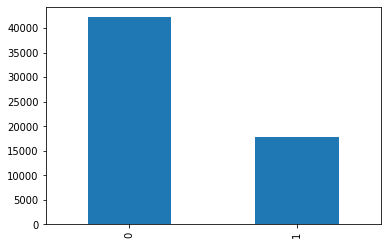

In [ ]:
# посмотрим на распределение классов у целевой переменной  
# видим, что датасет несблансированный  

train['Y'].value_counts().plot(kind='bar');  

In [ ]:
# перевес  в класс 0 не очень большой, к тому же метрика ROC-AUC  устойчива к дисбалансу классов, поэтому  менять соотношение  не будем  

print('class_1: ', train['Y'].value_counts()[1], 'share: {:.2%}'.format(train['Y'].value_counts()[1] / len(train)))  
print('class_0: ', train['Y'].value_counts()[0], 'share: {:.2%}'.format(train['Y'].value_counts()[0] / len(train)))  

class_1:  17795 share: 29.66%
class_0:  42205 share: 70.34%


In [ ]:
# преобразование столбца с датами и добавление новых признаков на их основе  

train.DT = pd.to_datetime(train.DT)  

train['year'] = train['DT'].dt.year  
train['month'] = train['DT'].dt.month
train['day'] = train['DT'].dt.day  
train['hour'] = train['DT'].dt.hour  
train['day_of_week'] = train.DT.dt.weekday  

test.DT = pd.to_datetime(test.DT)  

test['year'] = test['DT'].dt.year
test['month'] = test['DT'].dt.month
test['day'] = test['DT'].dt.day  
test['hour'] = train['DT'].dt.hour   
test['day_of_week'] = test.DT.dt.weekday  

# Анализ отдельных признаков  

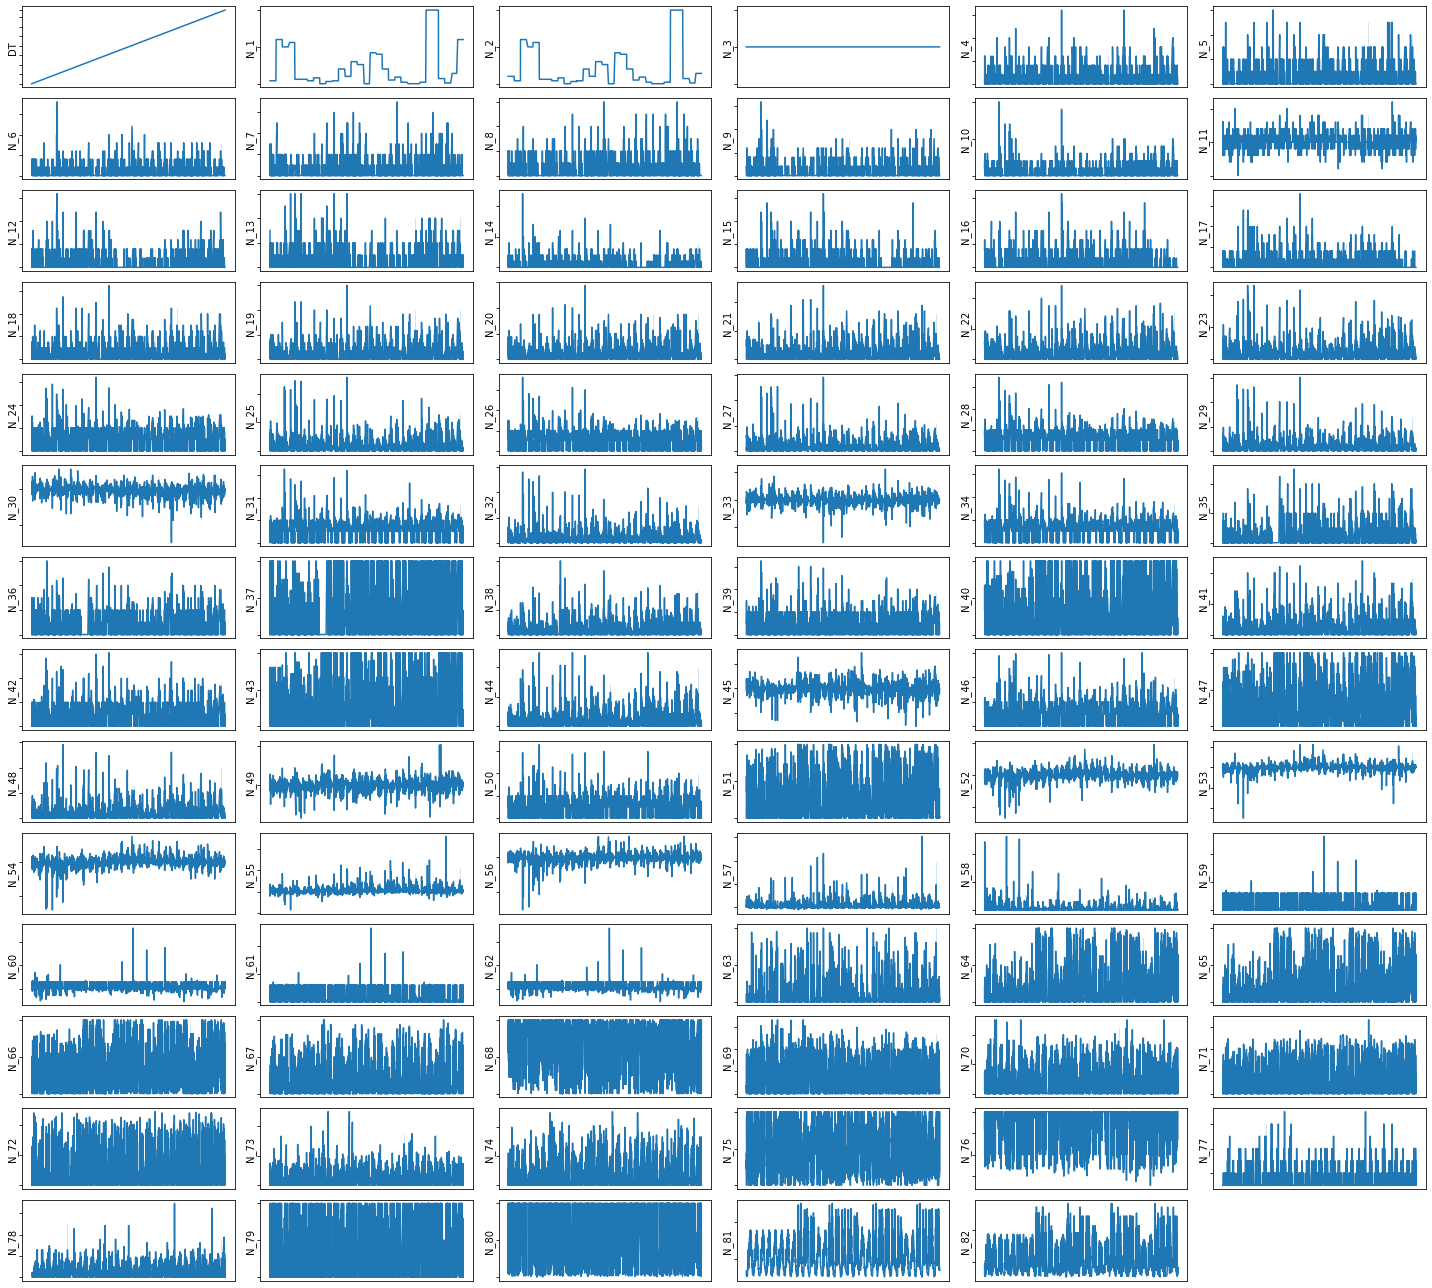

In [ ]:
# посмотрим на значения параметров N, распределенных во времени, за первый месяц наблюдений  

train_N = train.drop(['C_1', 'C_2', 'C_3', 'C_4', 'ID', 'year', 'month', 'day', 'hour', 'Y'], axis=1).columns

rows = 14  
cols = 6  
c = 1  

sns.set_palette(sns.color_palette("tab10"))  
fig = plt.figure(figsize=(20,18))

for i in train_N:
    plt.subplot(rows, cols, c)  
    sns.lineplot(x=train[train['DT']<'2019-02-01 00:00:00']['DT'], y=train[train['DT']<'2019-02-01 00:00:00'][i]).set(xlabel=None)  
    c = c + 1  
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, labelleft=False)  
    plt.tight_layout()  

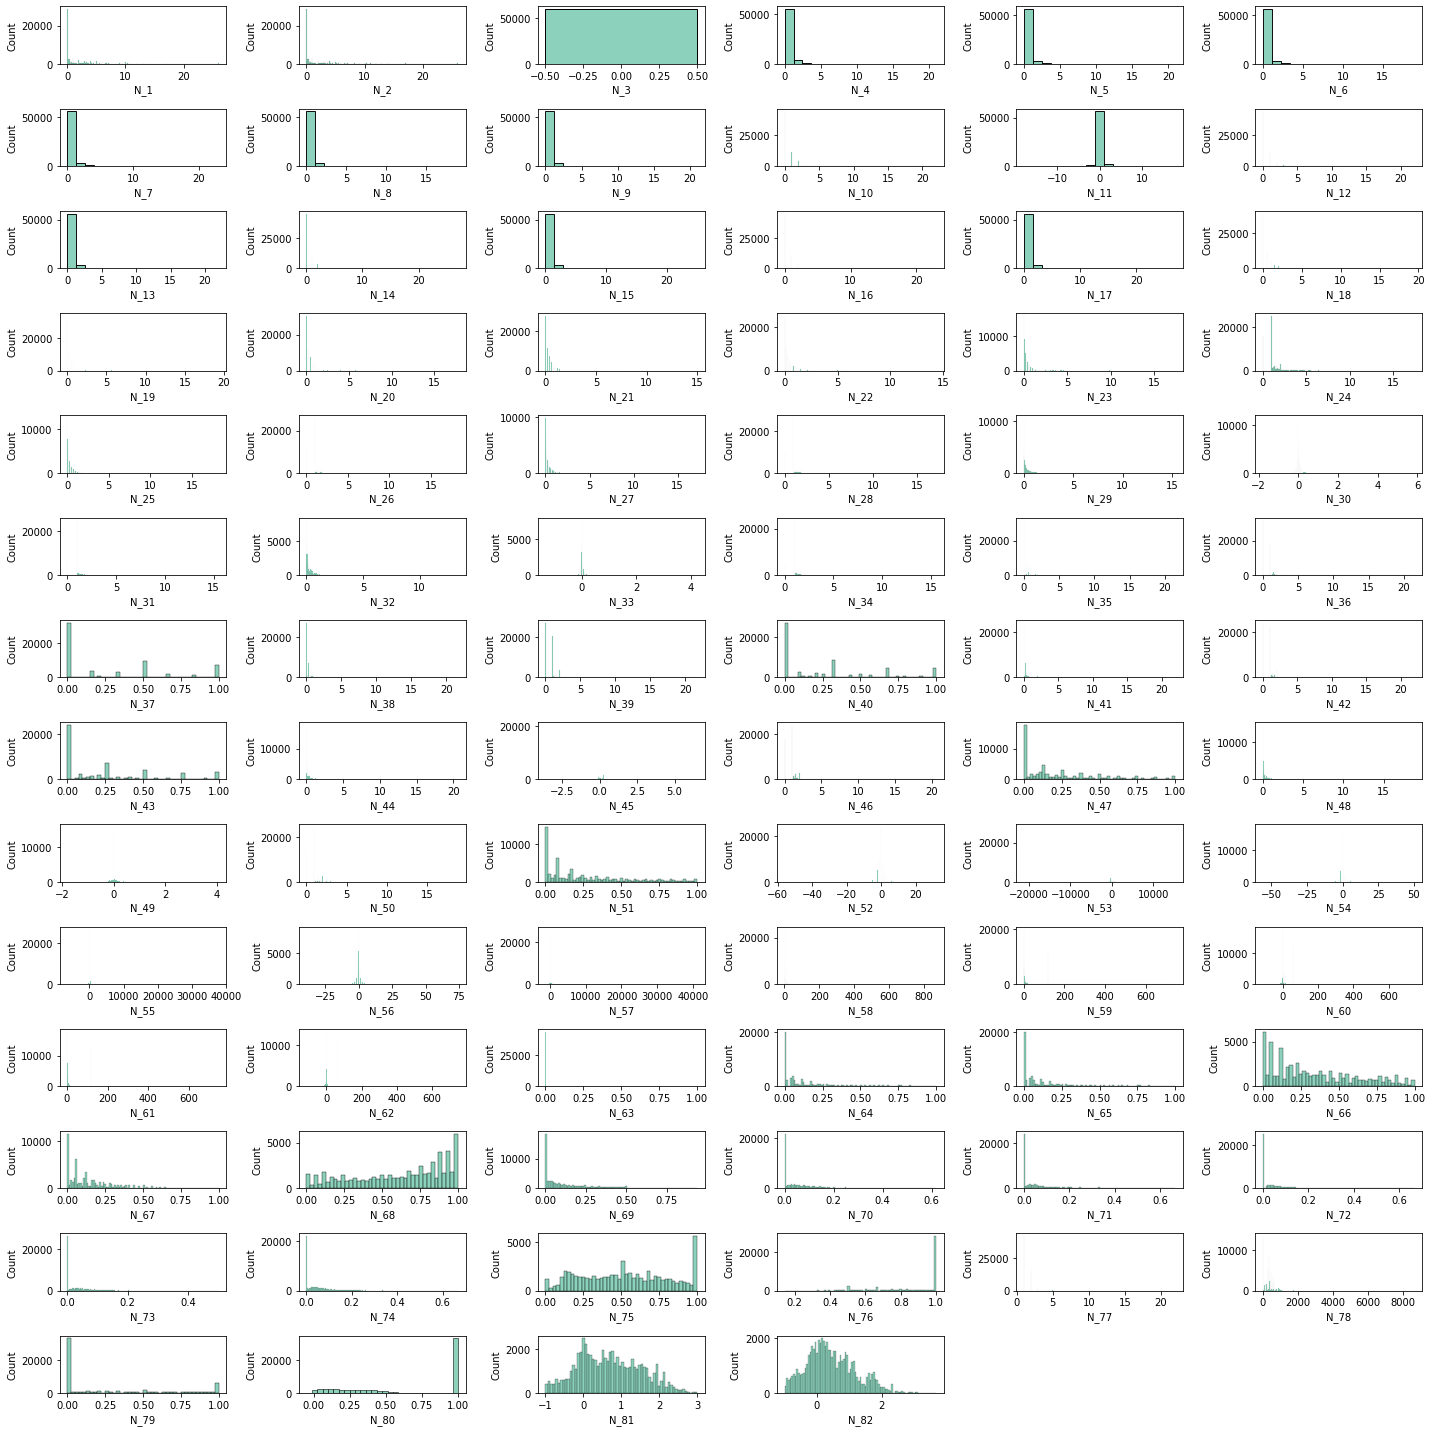

In [ ]:
# посмотрим на распределение  признаков  

train_N = train.drop(['C_1', 'C_2', 'C_3', 'C_4', 'ID', 'DT', 'year', 'month', 'day', 'hour', 'Y'], axis=1).columns  

rows = 14  
cols = 6  
c = 1  

sns.set_palette(sns.color_palette("Set2"))  
fig = plt.figure(figsize=(20,20))  

for i in train_N:
    plt.subplot(rows, cols, c)  
    sns.histplot(train[i])  
    c = c + 1  
    plt.tight_layout()  

In [ ]:
# призник N_3 содержит только одно значение, его можно удалить  

train.N_3.unique()  

array([0])

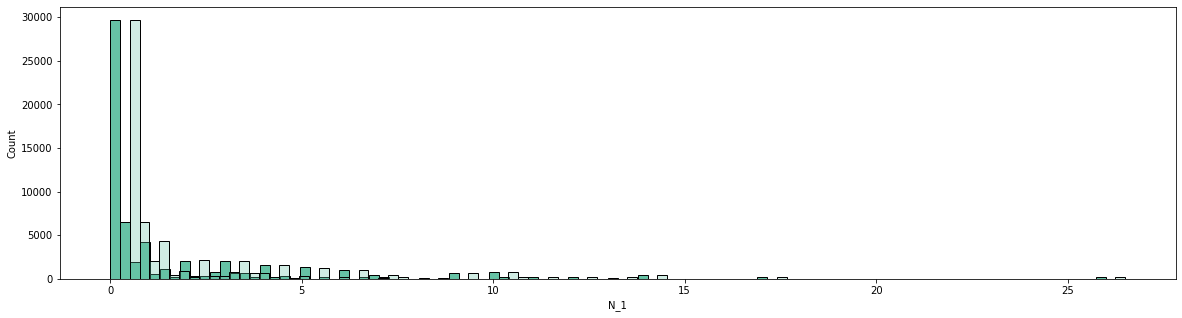

In [ ]:
# графики N_1 и N_2  похожи, посмотрим на распределение значений этих признаков и корреляцию  
# видим, что распределение значений у них совпадает, при этом корреляция не очень высокая  
# скорее всего, эти признаки можно определить в одну групп - G_1  
# значения данных призакнов сильно скошено в сторону 0, добавим новые признаки  для 'N_1', 'N_2' - 1, если значение совпадает с наиболее частым  и 0 для всех остальных  

plt.figure(figsize=(20,5))
sns.set_palette(sns.color_palette("Set2"))  

sns.histplot(train['N_1'], bins=100, alpha=1)  
sns.histplot(train['N_2']+0.5, bins=100, alpha=0.3);  

In [ ]:
train_df = train[['N_1', 'N_2', 'Y']]  
train_df_corr = train_df.corr().style.background_gradient().set_precision(2)  

train_df_corr  

,N_1,N_2,Y
N_1,1.00,0.40,-0.01
N_2,0.40,1.00,-0.02
Y,-0.01,-0.02,1.00


In [ ]:
# значения N_1 и N_2 полносью совпадаютдают  

d = {'N_1': sorted(train.N_1.unique()), 'N_2': sorted(train.N_2.unique())}  
df_N = pd.DataFrame(data=d)  

df_N.sort_values(by='N_1').head()  

,N_1,N_2
0,0.0,0.0
1,0.1,0.1
2,0.2,0.2
3,0.3,0.3
4,0.4,0.4


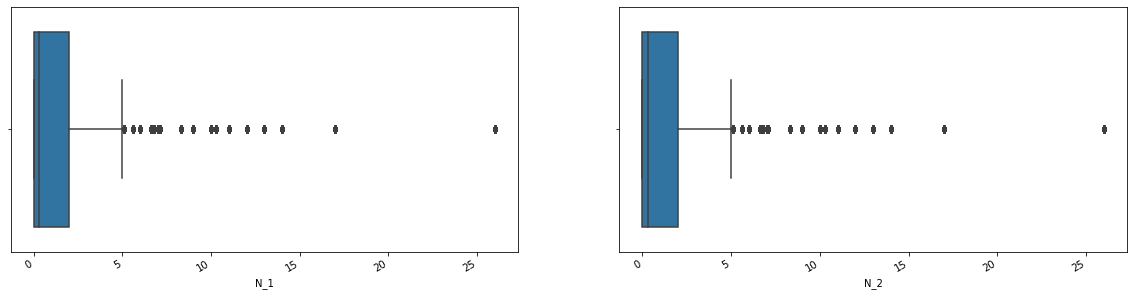

In [ ]:
# проверим данные признаки на выбросы  

fig, axes = plt.subplots(1, 2, figsize=(20,5))  
fig.autofmt_xdate()

n = 0  

for col in train[['N_1', 'N_2']].columns:  
  sns.boxplot(train[col], ax=axes[n])  
  n = n + 1  

In [ ]:
# видим, что есть выбросы - удалим их  

train = train[(train.N_1 < 25) & (train.N_2 < 25)]  

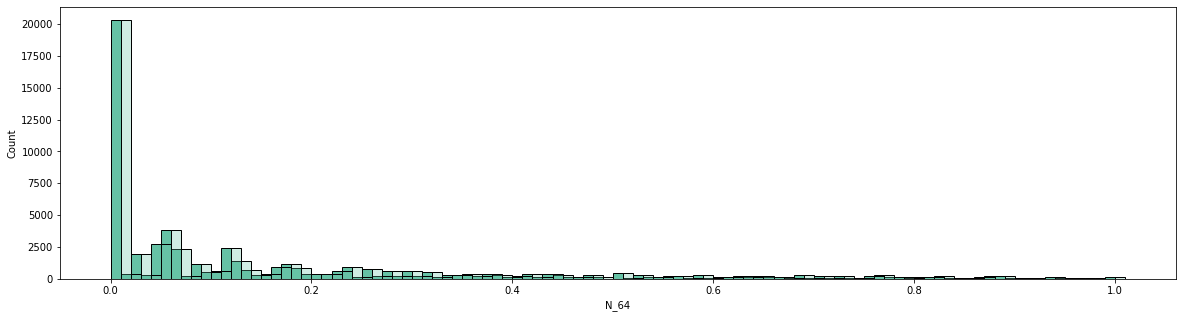

In [ ]:
# графики N_64 и N_65  похожи, посмотрим на распределение значений этих признаков и корреляцию  
# видим, что эти признаки полностю совпадают, удалим один из них  

plt.figure(figsize=(20,5))
sns.set_palette(sns.color_palette("Set2"))  

sns.histplot(train['N_64'], bins=100, alpha=1)  
sns.histplot(train['N_65']+0.01, bins=100, alpha=0.3);  

In [ ]:
len(train[['N_64', 'N_65']][train.N_64 == train.N_65])

60000

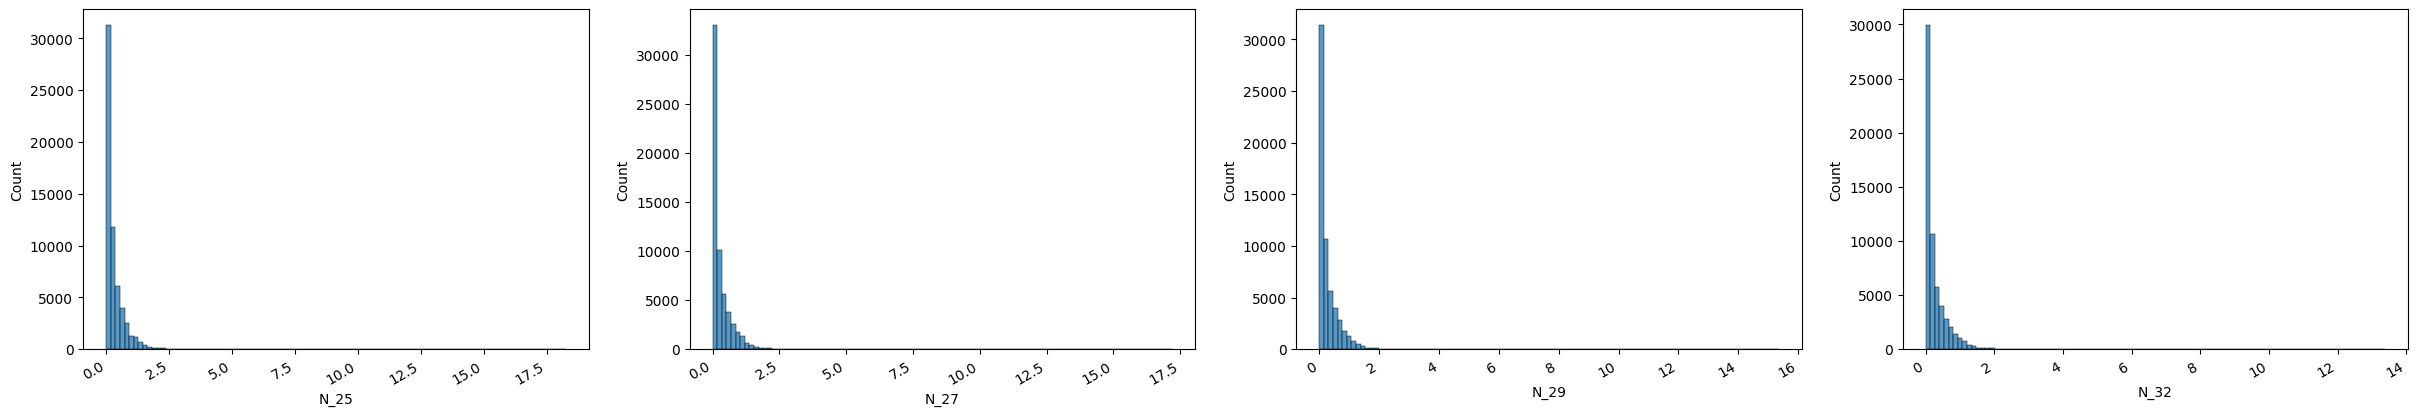

In [ ]:
# графики N_25, N_27, N_29, N_32  похожи, посмотрим на распределение значений этих признаков и корреляцию  

sns.set_palette(sns.color_palette("tab10"))  

fig, axes = plt.subplots(1, 4, figsize=(30,5), dpi=100)  
fig.autofmt_xdate()

n = 0  

for col in train[['N_25', 'N_27', 'N_29', 'N_32']].columns:  
  sns.histplot(train[col], bins=100, ax=axes[n])  
  n = n + 1  

In [ ]:
# видим, что признаки сильно скоррелированы между собой, можно оставить только один из них, корреляция с Y выше  у N_32, оставим только его  

train_df = train[['N_25', 'N_27', 'N_29', 'N_32', 'Y']]  
train_df_corr = train_df.corr().style.background_gradient().set_precision(2)  

train_df_corr  

,N_25,N_27,N_29,N_32,Y
N_25,1.00,0.99,0.95,0.91,0.37
N_27,0.99,1.00,0.97,0.93,0.37
N_29,0.95,0.97,1.00,0.98,0.38
N_32,0.91,0.93,0.98,1.00,0.40
Y,0.37,0.37,0.38,0.40,1.00


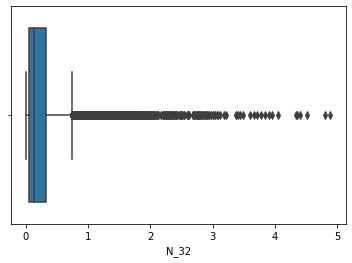

In [ ]:
# проверим  оставшийся признак на выбросы  

sns.boxplot(train.N_32);  

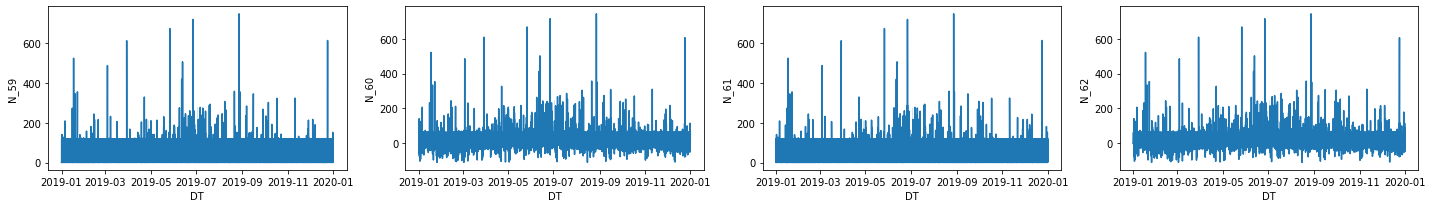

In [ ]:
# у признаков N_59, N_60, N_61, N_62  наиболее выражено одно значение, при этом остальные значения выглядят как выбросы, также графики визуально похожи   
# посмотрим на эти признаки за весь период  

rows = 1  
cols = 4  
c = 1  

fig = plt.figure(figsize=(20,3))

for i in train[['N_59', 'N_60', 'N_61', 'N_62']]:
    plt.subplot(rows, cols, c)  
    sns.lineplot(x=train['DT'], y=train[i])  
    c = c + 1  
    plt.tight_layout()  

In [ ]:
# посмотрим на корреляцию всех четырех признаков между собой и целевой переменной  
# видим, что признаки сильно скоррелированы между собой, можно оставить только один из них, корреляция с Y выше у N_59 и N_61, оставим первый - N_59  

train_df = train[['N_59', 'N_60', 'N_61', 'N_62', 'Y']]  
train_df_corr = train_df.corr().style.background_gradient().set_precision(2)  

train_df_corr  

,N_59,N_60,N_61,N_62,Y
N_59,1.00,0.95,0.99,0.93,-0.18
N_60,0.95,1.00,0.93,0.98,-0.15
N_61,0.99,0.93,1.00,0.94,-0.18
N_62,0.93,0.98,0.94,1.00,-0.15
Y,-0.18,-0.15,-0.18,-0.15,1.00


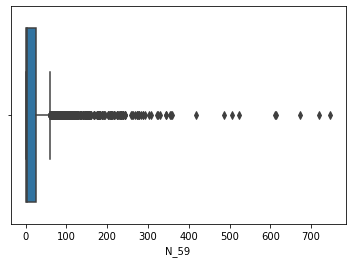

In [ ]:
# проверим  оставшийся признак на выбросы  

sns.boxplot(train.N_59);  

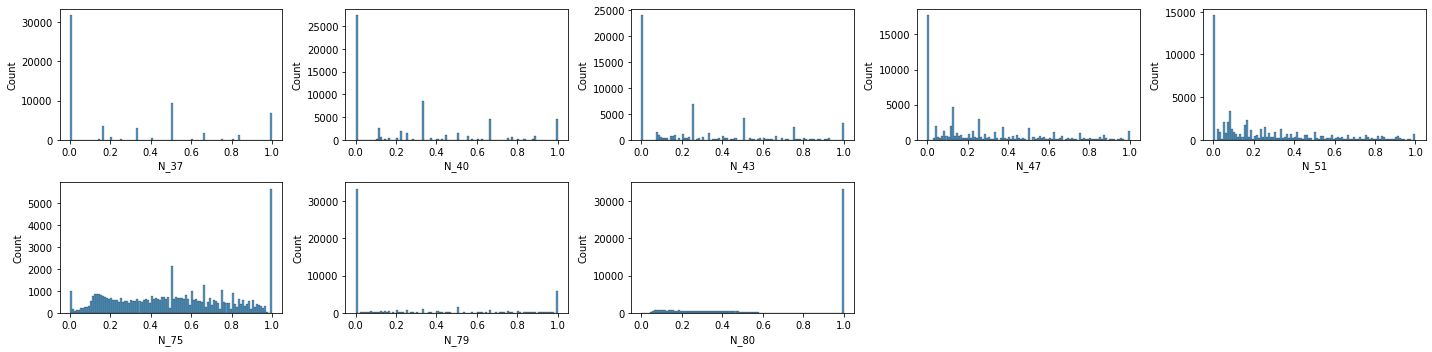

In [ ]:
# графики N_37, N_40, N_43, N_47, N_51, N_75, N_79, N_80  похожи, посмотрим на распределение значений этих признаков и корреляцию  
#  видим, что распределение  у части признаков  скошено в 0 или 1   
# добавим новые признаки  для 'N_37', 'N_43', 'N_51', 'N_75', 'N_79', 'N_80' - 1, если значение совпадает с наиболее частым  и 0 для всех остальных  

train_N = train[['N_37', 'N_40', 'N_43', 'N_47', 'N_51', 'N_75', 'N_79', 'N_80']].columns

rows = 2  
cols = 5  
c = 1  

fig = plt.figure(figsize=(20,5))

for i in train_N:
    plt.subplot(rows, cols, c)  
    sns.histplot(train[i], bins=100)  
    c = c + 1  
    plt.tight_layout()  

In [ ]:
max_df = pd.DataFrame(columns=('col', 'value', 'count'))  

for i in train_N:  
  g = train.groupby([i])[i].count()  
  g_df = pd.DataFrame({'col': i, 'value': g.index, 'count': g})  
  g_df = g_df[g_df['count'] == g_df['count'].max()][['col', 'value', 'count']]

  max_df = pd.concat([max_df, g_df], axis=0)  

max_df['%'] = max_df['count'] / 60000 * 100  

max_df  

,col,value,count,%
0.0,N_37,0.0,31734,52.89
0.0,N_40,0.0,27336,45.56
0.0,N_43,0.0,24016,40.026667
0.0,N_47,0.0,17693,29.488333
0.0,N_51,0.0,14562,24.27
1.0,N_75,1.0,5663,9.438333
0.0,N_79,0.0,33331,55.551667
1.0,N_80,1.0,33331,55.551667


In [ ]:
# посмотрим на корреляцию всех  признаков между собой и целевой переменной  
# видим, что часть признаков сильно скоррелирована между собой, часть из них можно удалить: N_40, N_47  

train_df = train[['N_37', 'N_40', 'N_43', 'N_47', 'N_51', 'N_75', 'N_79', 'N_80', 'Y']]  
train_df_corr = train_df.corr().style.background_gradient().set_precision(2)  

train_df_corr  

,N_37,N_40,N_43,N_47,N_51,N_75,N_79,N_80,Y
N_37,1.00,0.92,0.87,0.79,0.76,-0.40,0.39,-0.32,0.32
N_40,0.92,1.00,0.95,0.87,0.83,-0.43,0.42,-0.34,0.34
N_43,0.87,0.95,1.00,0.92,0.88,-0.45,0.43,-0.35,0.35
N_47,0.79,0.87,0.92,1.00,0.97,-0.48,0.46,-0.37,0.37
N_51,0.76,0.83,0.88,0.97,1.00,-0.50,0.47,-0.38,0.37
N_75,-0.40,-0.43,-0.45,-0.48,-0.50,1.00,-0.44,0.45,-0.32
N_79,0.39,0.42,0.43,0.46,0.47,-0.44,1.00,-0.76,0.61
N_80,-0.32,-0.34,-0.35,-0.37,-0.38,0.45,-0.76,1.00,-0.43
Y,0.32,0.34,0.35,0.37,0.37,-0.32,0.61,-0.43,1.00


In [ ]:
# признаки N_79 и N_80 зеркально скошены в отношении значений 0 и 1 и довольно сильно скорреллированы между собой  
# скорее всего, эти признаки можно определеить в одну группу - G_2  

max_df[(max_df['col'] == 'N_79') | (max_df['col'] == 'N_80')]  

,col,value,count,%
0.0,N_79,0.0,33331,55.551667
1.0,N_80,1.0,33331,55.551667


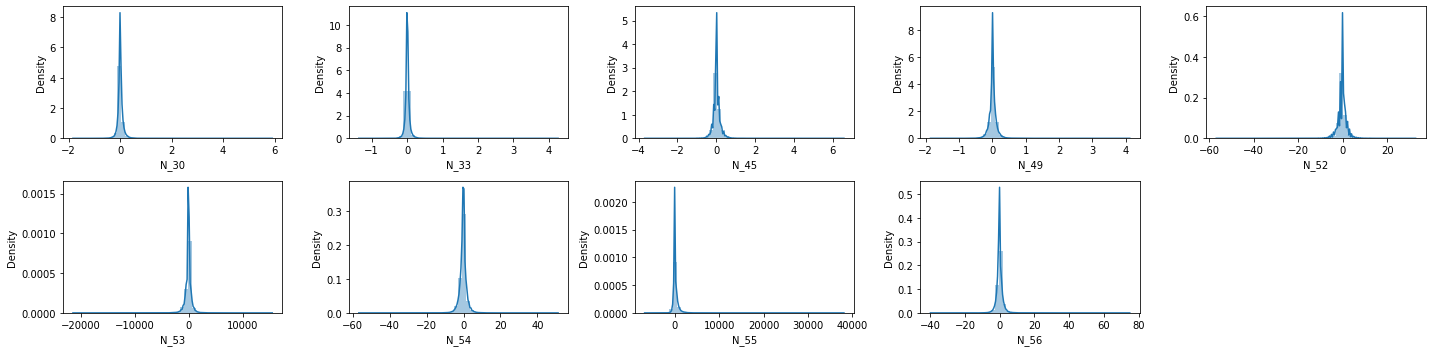

In [ ]:
# графики N_30, N_33, N_45, N_49, N_52, N_53, N_54, N_55, N_56  похожи, посмотрим на распределение значений этих признаков  
# по схожему характеру распределения  эти признаки можно определеить в одну групп - G_3  

train_N = train[['N_30', 'N_33', 'N_45', 'N_49', 'N_52', 'N_53', 'N_54', 'N_55', 'N_56']].columns  

rows = 2  
cols = 5  
c = 1  

fig = plt.figure(figsize=(20,5))

for i in train_N:
    plt.subplot(rows, cols, c)  
    sns.distplot(train[i])  
    c = c + 1  
    plt.tight_layout()  

In [ ]:
# видно, что у данных есть большие хвосты, посмотрим сколько значений в этих признаках встречаются только 1 раз  

one_df = pd.DataFrame(columns=('col', 'value', 'count'))  

for i in train_N:  
  g = train.groupby([i])[i].count()  
  g_df = pd.DataFrame({'col': i, 'value': g.index, 'count': g})  
  g_df = g_df[g_df['count'] == 1]

  one_df = pd.concat([one_df, g_df], axis=0)  

one_df['%'] = one_df['count'] / 60000 * 100  

one_df_sum = one_df.groupby(['col'])['count'].sum()  

one_df_sum  

col
N_30      83
N_33     144
N_45     978
N_49    1422
N_52      20
N_53     457
N_54      31
N_55     676
N_56      63
Name: count, dtype: object

In [ ]:
# удалим строки с этими значениями из датасета  

one_df = one_df.pivot(columns='col', values='value')

for i in list(one_df.columns):  
  train = train.loc[~train[i].isin(list(one_df[i]))]  

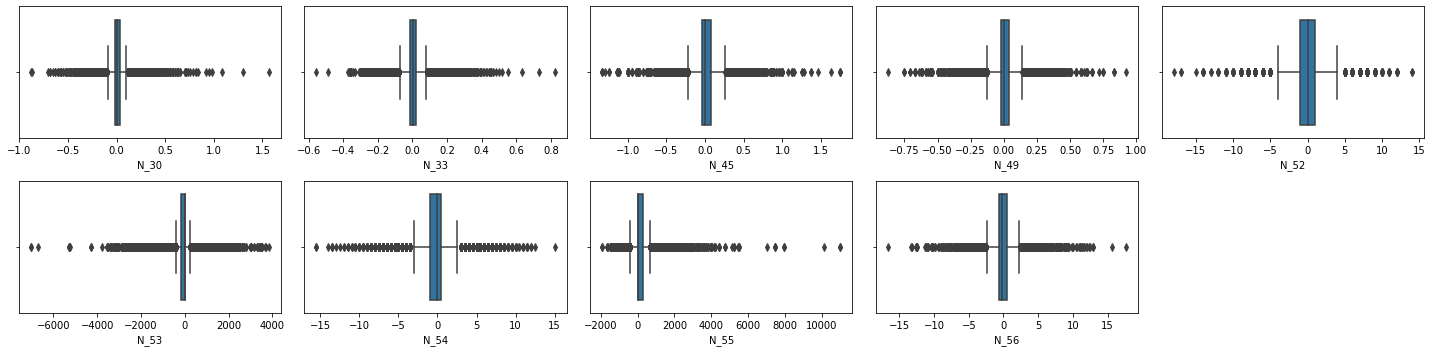

In [ ]:
# проверим данные признаки на выбросы  

rows = 2  
cols = 5  
c = 1  

fig = plt.figure(figsize=(20,5))

for i in train[['N_30', 'N_33', 'N_45', 'N_49', 'N_52', 'N_53', 'N_54', 'N_55', 'N_56']].columns:
    plt.subplot(rows, cols, c)  
    sns.boxplot(train[i])  
    c = c + 1  
    plt.tight_layout()  

In [ ]:
# видим, что есть выбросы - удалим их  

train = train[(train.N_30 < 1.5) & (train.N_53 > -6000) & (train.N_54 > -15) & (train.N_54 < 15) & (train.N_55 < 10000) & (train.N_56 > -15) & (train.N_56 < 15)]  

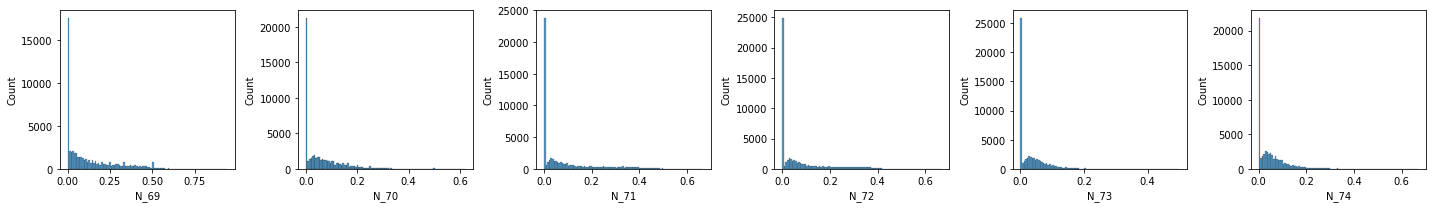

In [ ]:
# графики N_69, N_70, N_71, N_72, N_73, N_74  похожи, посмотрим на распределение значений этих признаков и корреляцию  
#  видим, что распределение  у этих признаков скошено в 0   
# объединим эти признаки в одну группу - G_4  
# добавим новые признаки - 1, если значение совпадает с наиболее частым  и 0 для всех остальных  

train_N = train[['N_69', 'N_70', 'N_71', 'N_72', 'N_73', 'N_74']].columns  

rows = 1  
cols = 6  
c = 1  

fig = plt.figure(figsize=(20,3))

for i in train_N:
    plt.subplot(rows, cols, c)  
    sns.histplot(train[i], bins=100)  
    c = c + 1  
    plt.tight_layout()  

In [ ]:
max_df = pd.DataFrame(columns=('col', 'value', 'count'))  

for i in train_N:  
  g = train.groupby([i])[i].count()  
  g_df = pd.DataFrame({'col': i, 'value': g.index, 'count': g})  
  g_df = g_df[g_df['count'] == g_df['count'].max()][['col', 'value', 'count']]

  max_df = pd.concat([max_df, g_df], axis=0)  

max_df['%'] = max_df['count'] / 60000 * 100  

max_df  

,col,value,count,%
0.0,N_69,0.0,16666,27.776667
0.0,N_70,0.0,21196,35.326667
0.0,N_71,0.0,23746,39.576667
0.0,N_72,0.0,24849,41.415
0.0,N_73,0.0,25849,43.081667
0.0,N_74,0.0,21380,35.633333


In [ ]:
# между собой признаки скоррелированы не сильно   

train_df = train[['N_69', 'N_70', 'N_71', 'N_72', 'N_73', 'N_74', 'Y']]  
train_df_corr = train_df.corr().style.background_gradient().set_precision(2)  

train_df_corr  

,N_69,N_70,N_71,N_72,N_73,N_74,Y
N_69,1.00,0.12,-0.22,-0.23,0.07,-0.08,0.23
N_70,0.12,1.00,-0.01,-0.01,0.48,-0.04,0.16
N_71,-0.22,-0.01,1.00,0.84,0.05,-0.06,0.19
N_72,-0.23,-0.01,0.84,1.00,0.07,-0.01,0.17
N_73,0.07,0.48,0.05,0.07,1.00,0.10,0.11
N_74,-0.08,-0.04,-0.06,-0.01,0.10,1.00,-0.05
Y,0.23,0.16,0.19,0.17,0.11,-0.05,1.00


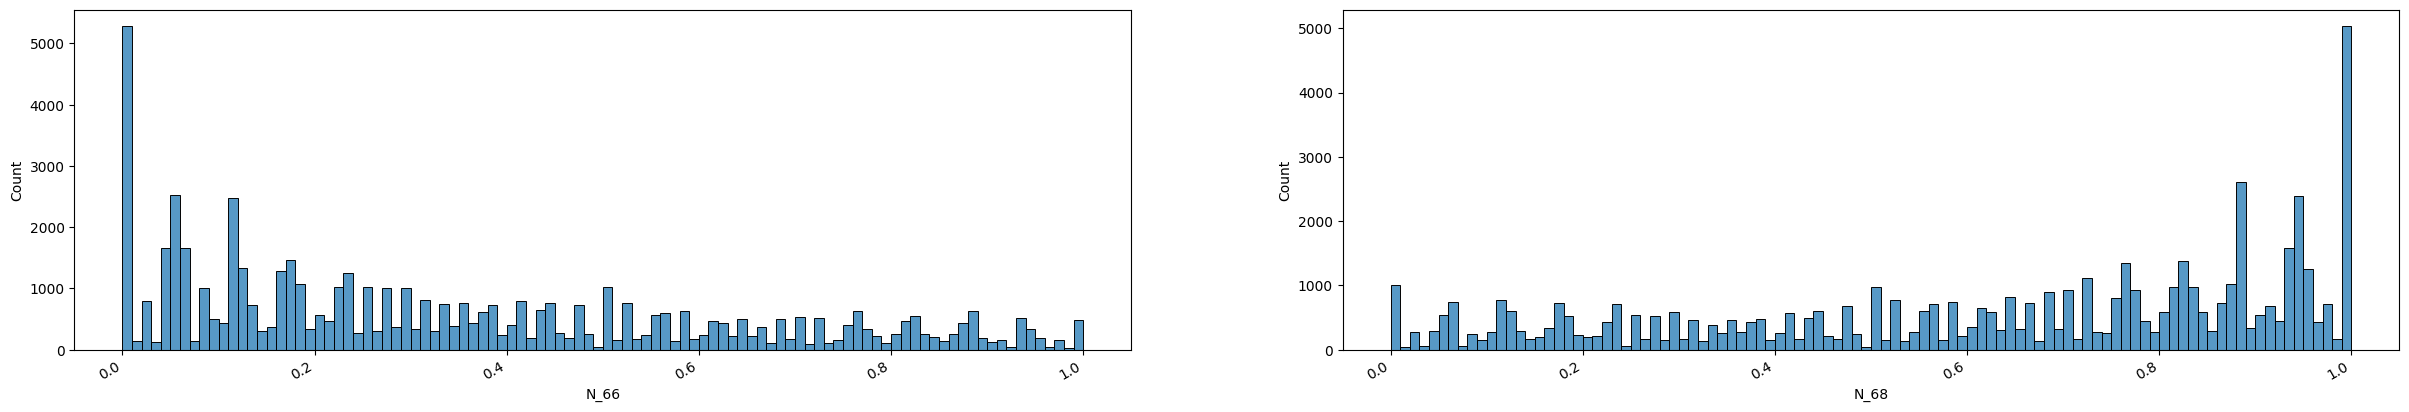

In [ ]:
# графики N_66, N_68 похожи - зеркально отражены, посмотрим на распределение значений этих признаков и корреляцию  
# объединим эти признаки в одну группу - G_5  

sns.set_palette(sns.color_palette("tab10"))  

fig, axes = plt.subplots(1, 2, figsize=(30,5), dpi=100)  
fig.autofmt_xdate()

n = 0  

for col in train[['N_66', 'N_68']].columns:  
  sns.histplot(train[col], bins=100, ax=axes[n])  
  n = n + 1  

In [ ]:
# распределения немного скошены в 0 и 1, но не критично  

max_df = pd.DataFrame(columns=('col', 'value', 'count'))  

for i in train[['N_66', 'N_68']].columns:  
  g = train.groupby([i])[i].count()  
  g_df = pd.DataFrame({'col': i, 'value': g.index, 'count': g})  
  g_df = g_df[g_df['count'] == g_df['count'].max()][['col', 'value', 'count']]

  max_df = pd.concat([max_df, g_df], axis=0)  

max_df['%'] = max_df['count'] / 60000 * 100  

max_df  

,col,value,count,%
0.0,N_66,0.0,5289,8.815
1.0,N_68,1.0,5039,8.398333


In [ ]:
# корреляция высокая, объединим их в одну группу G_8  

train_df = train[['N_66', 'N_68', 'Y']]  
train_df_corr = train_df.corr().style.background_gradient().set_precision(2)  

train_df_corr  

,N_66,N_68,Y
N_66,1.00,-0.95,0.09
N_68,-0.95,1.00,-0.14
Y,0.09,-0.14,1.00


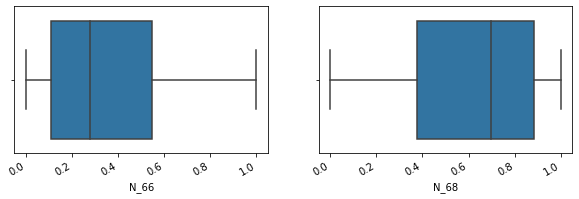

In [ ]:
# проверим данные признаки на выбросы  

fig, axes = plt.subplots(1, 2, figsize=(10,3))  
fig.autofmt_xdate()

n = 0  

for col in train[['N_66', 'N_68']].columns:  
  sns.boxplot(train[col], ax=axes[n])  
  n = n + 1  

In [ ]:
# посмотрим на группы признаков с одинаковым числом уникальных значений  

l = []  
m = []  

for i in train.drop(['year', 'N_64', 'N_65', 'C_1', 'C_2', 'N_1', 'N_2'], axis=1).columns:
    l.append(i)  
    m.append(len(train[i].unique()))  

d = {'feature':l, 'num':m}
df_unique = pd.DataFrame(data=d)  

df_unique_count = df_unique.groupby('num', as_index=False).count()  
df_unique_count = df_unique_count[df_unique_count.feature > 1]  

df_unique = df_unique[df_unique.num.isin(list(df_unique_count.num))].sort_values(by='num')  

df_unique[df_unique.num > 2]

,feature,num
8,N_9,8
9,N_10,8
13,N_14,8
16,N_17,9
5,N_6,9
6,N_7,9
14,N_15,9
12,N_13,9
3,N_4,10
15,N_16,10


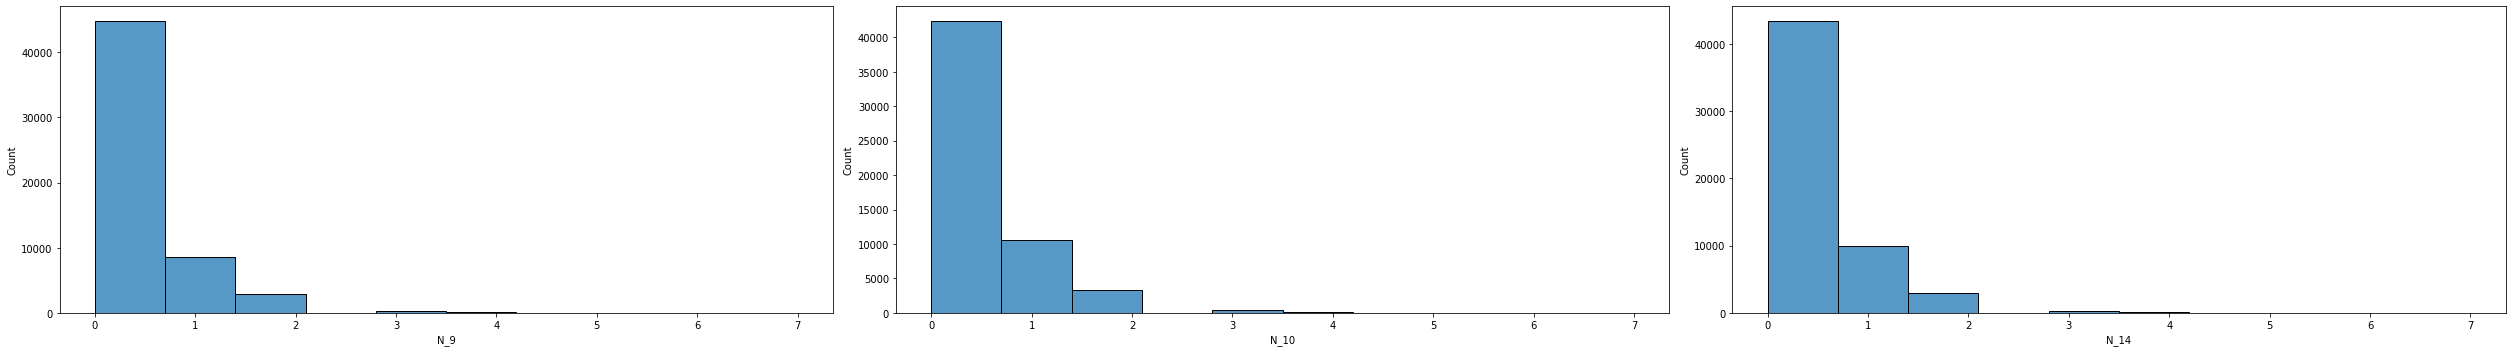

In [ ]:
# посмотрим на распределение признаков с количеством значений = 8  
# видно, что распределение у признаков  очень похоже  
# у всех этих признаков сильно выражено значение 0, остальные 7 значений приходятся всего на 25-30%  
# добавим признаки 1 и 0 для основного и всех остальных значений соответственно  

train_N = list(train[['N_9', 'N_10', 'N_14']].columns)  

rows = 1  
cols = 3  
c = 1  

fig = plt.figure(figsize=(35,5))  

for i in train_N:
    plt.subplot(rows, cols, c)  
    sns.histplot(train[i], bins=10)  
    c = c + 1  
    plt.tight_layout()  

In [ ]:
# выведем наиболее частое значение и процент от общего количества для него, для всех признаков это значение - 0  

max_df = pd.DataFrame(columns=('col', 'value', 'count'))  

for i in train_N:  
  g = train.groupby([i])[i].count()  
  g_df = pd.DataFrame({'col': i, 'value': g.index, 'count': g})  
  g_df = g_df[g_df['count'] == g_df['count'].max()][['col', 'value', 'count']]

  max_df = pd.concat([max_df, g_df], axis=0)  

max_df['%'] = max_df['count'] / 60000 * 100  

max_df  

,col,value,count,%
0,N_9,0,44813,74.688333
0,N_10,0,42368,70.613333
0,N_14,0,43387,72.311667


In [ ]:
# корреляция между собой у этих признаков не очень высокая, при этом корреляция с целевой переменной похожа по всем признакам, скорее всего эти признаки можно объединить в группу G_6  

train_df = train[['N_9', 'N_10', 'N_14', 'Y']]  
train_df_corr = train_df.corr().style.background_gradient().set_precision(2)  

train_df_corr  

,N_9,N_10,N_14,Y
N_9,1.00,0.38,0.31,0.26
N_10,0.38,1.00,0.37,0.28
N_14,0.31,0.37,1.00,0.26
Y,0.26,0.28,0.26,1.00


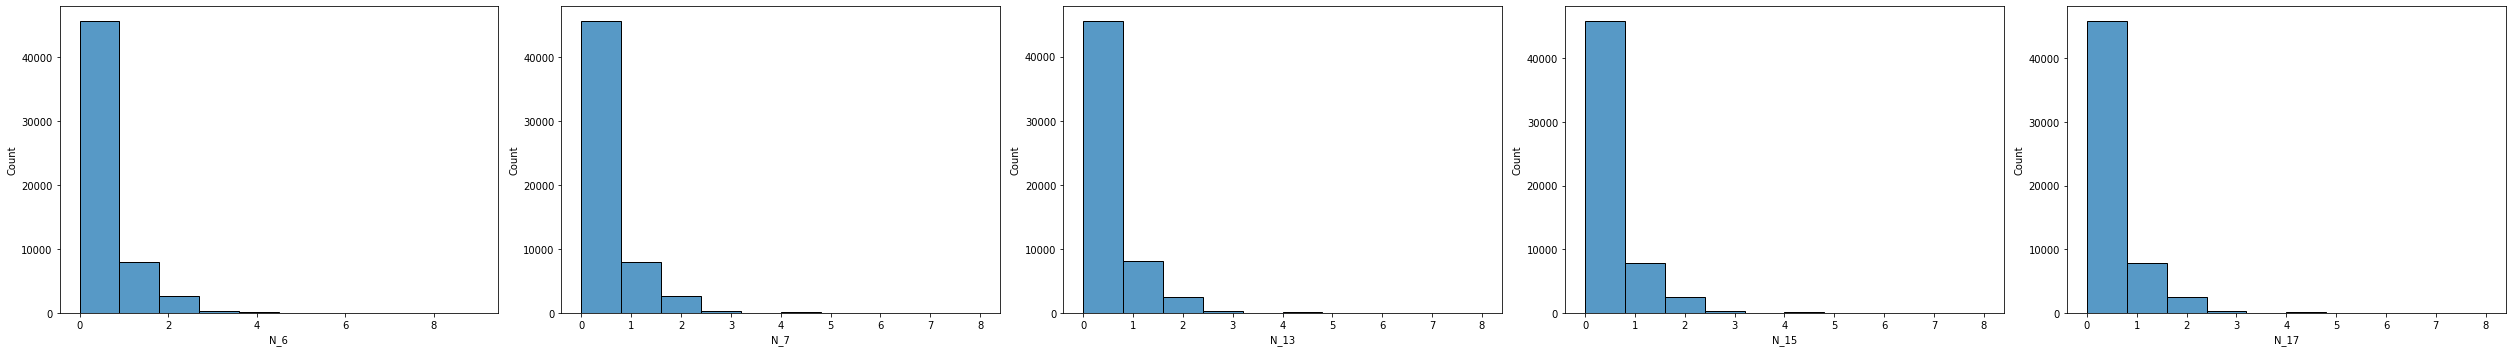

In [ ]:
# посмотрим на распределение признаков с количеством значений = 9  
# видно, что распределение у этих признаков очень похоже, объединим их в одну группу G_7   
# у всех этих признаков сильно выражено значение 0, остальные 8 значений приходятся всего на 20-30%  
# добавим признаки 1 и 0  для основного и всех остальных значений соответственно   

train_N = list(train[['N_6', 'N_7', 'N_13', 'N_15', 'N_17']].columns)

rows = 1  
cols = 5  
c = 1  

fig = plt.figure(figsize=(35,5))  

for i in train_N:
    plt.subplot(rows, cols, c)  
    sns.histplot(train[i], bins=10)  
    c = c + 1  
    plt.tight_layout()  

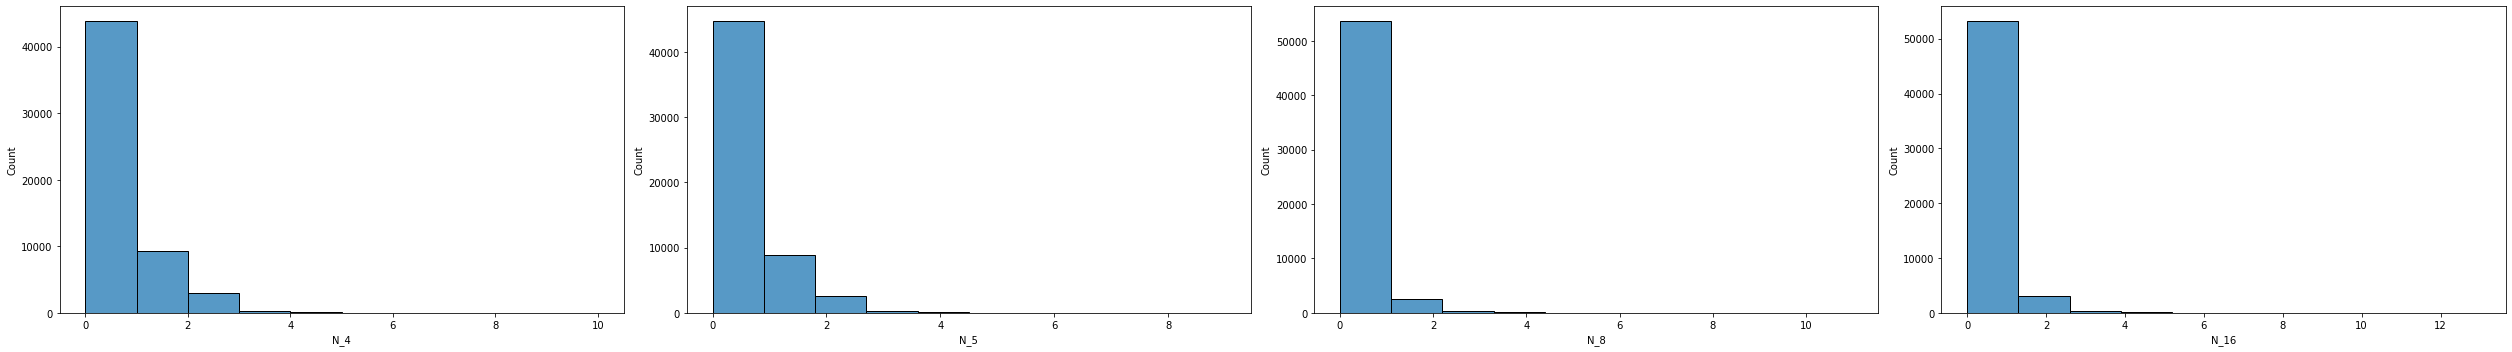

In [ ]:
# посмотрим на распределение признаков с количеством значений = 10  
# видно, что распределение у признаков очень похоже, объединим их в группы G_8 ('N_4', 'N_5'), G_9 ('N_8', 'N_16')  
# у всех этих признаков сильно выражено значение 0, остальные 9 значений приходятся всего на 25-30%  
# добавим признаки 1 и 0 для основного и всех остальных значений соответственно  

train_N = list(train[['N_4', 'N_5', 'N_8', 'N_16']].columns)

rows = 1  
cols = 4  
c = 1  

fig = plt.figure(figsize=(35,5))  

for i in train_N:
    plt.subplot(rows, cols, c)  
    sns.histplot(train[i], bins=10)  
    c = c + 1  
    plt.tight_layout()  

In [ ]:
max_df = pd.DataFrame(columns=('col', 'value', 'count'))  

for i in train_N:  
  g = train.groupby([i])[i].count()  
  g_df = pd.DataFrame({'col': i, 'value': g.index, 'count': g})  
  g_df = g_df[g_df['count'] == g_df['count'].max()][['col', 'value', 'count']]

  max_df = pd.concat([max_df, g_df], axis=0)  

max_df['%'] = max_df['count'] / 60000 * 100  

max_df  

,col,value,count,%
0,N_4,0,43858,73.096667
0,N_5,0,44707,74.511667
0,N_8,0,45743,76.238333
0,N_16,0,43368,72.28


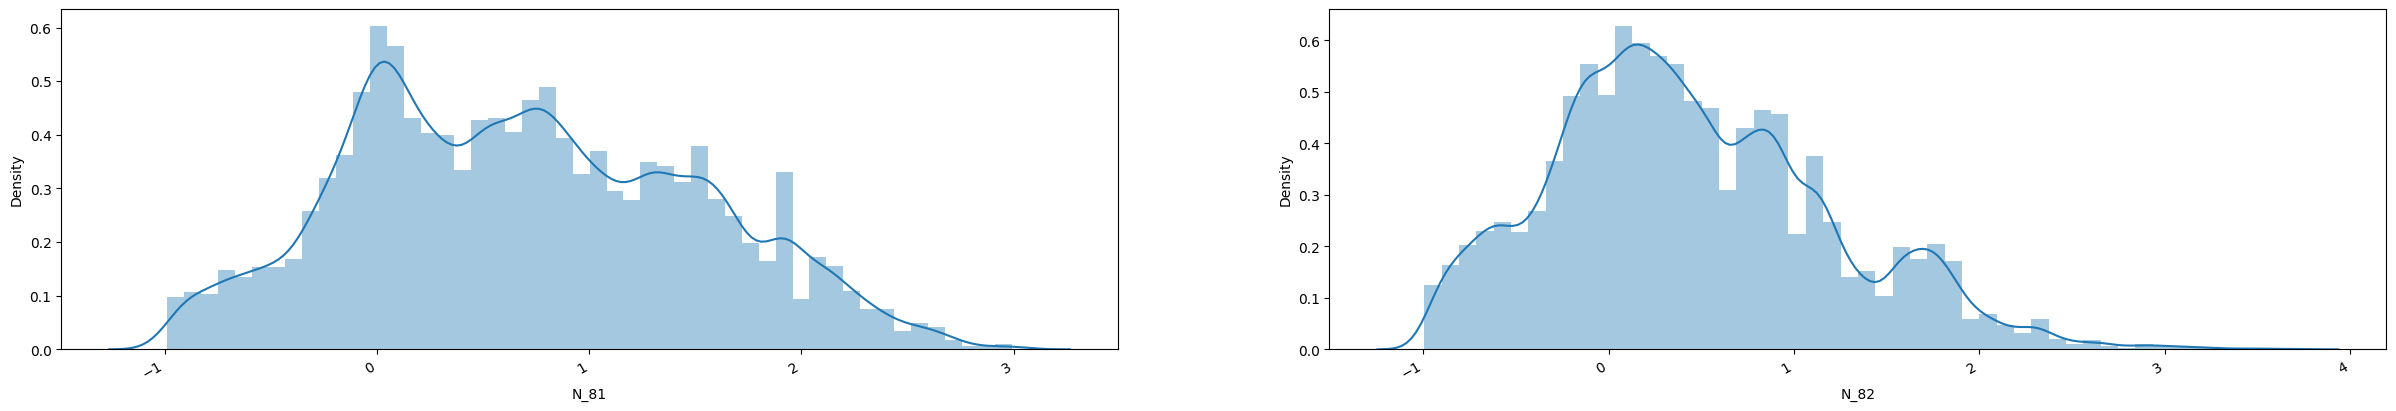

In [ ]:
# остальные признаки  
# графики N_81, N_82 похожи, посмотрим на распределение значений этих признаков  
# объединим эти признаки в одну группу - G_10  

sns.set_palette(sns.color_palette("tab10"))  

fig, axes = plt.subplots(1, 2, figsize=(30,5), dpi=100)  
fig.autofmt_xdate()

n = 0  

for col in train[['N_81', 'N_82']].columns:  
  sns.distplot(train[col], ax=axes[n])  
  n = n + 1  

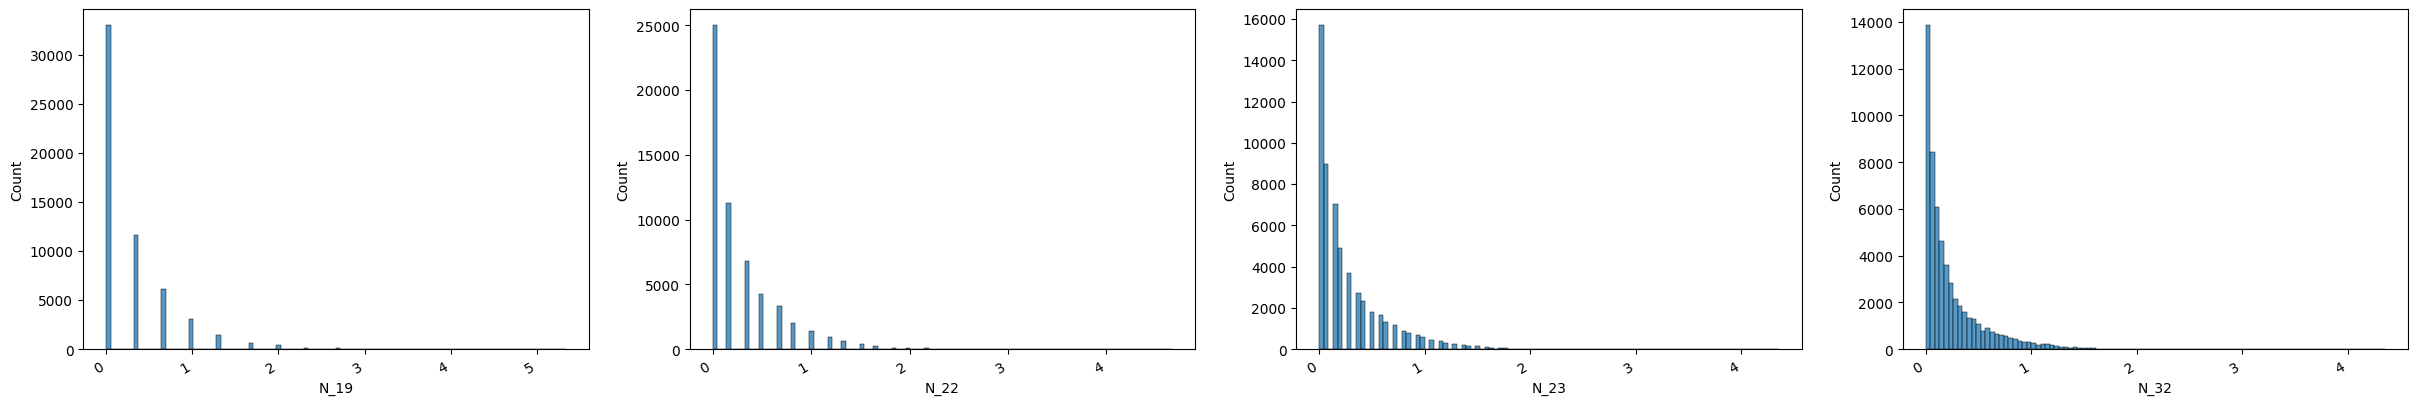

In [ ]:
# остальные признаки  
# графики N_19, N_22, N_23, N_32  похожи - имеют одинаковое распределение, но в каждом следующем признаке оно более плотное    
# объединим эти признаки в одну группу - G_11  

train_N = ['N_19', 'N_22', 'N_23', 'N_32']  

sns.set_palette(sns.color_palette("tab10"))  

fig, axes = plt.subplots(1, 4, figsize=(30,5))  

n = 0  

for col in train_N:  
  sns.histplot(train[col], bins=100, ax=axes[n])  
  n = n + 1  

In [ ]:
# корреляция между собой довольно высокая у всех признаков   

train_df = train[['N_19', 'N_22', 'N_23', 'N_32', 'Y']]  

train_df_corr = train_df.corr().style.background_gradient().set_precision(2)  

train_df_corr  

,N_19,N_22,N_23,N_32,Y
N_19,1.00,0.86,0.77,0.69,0.33
N_22,0.86,1.00,0.91,0.81,0.39
N_23,0.77,0.91,1.00,0.88,0.41
N_32,0.69,0.81,0.88,1.00,0.42
Y,0.33,0.39,0.41,0.42,1.00


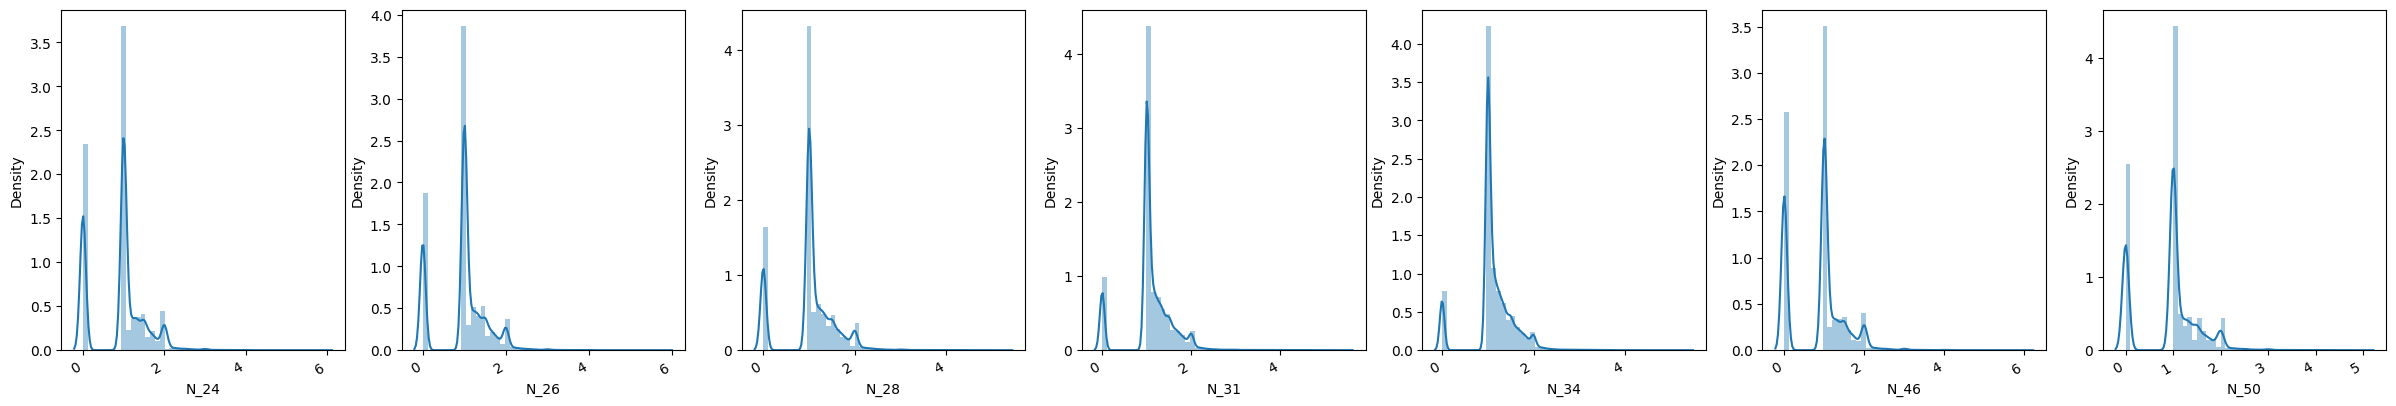

In [ ]:
# графики N_24, N_26, N_28, N_31, N_34, N_46, N_50 похожи, распределение у этих признаков одинаковое  с наиболее частым значением = 1  
# добавим категориальный признак со значениями 0, 1, 2 для значений 0, 1 и все остальные соответственно  
# объединим эти признаки в одну группу - G_12  

train_N = ['N_24', 'N_26', 'N_28', 'N_31', 'N_34', 'N_46', 'N_50']  

sns.set_palette(sns.color_palette("tab10"))  

fig, axes = plt.subplots(1, 7, figsize=(30,5), dpi=100)  
fig.autofmt_xdate()

n = 0  

for col in train_N:  
  sns.distplot(train[col], ax=axes[n])  
  n = n + 1  

In [ ]:
# корреляция между собой довольно высокая у всех признаков   

train_df = train[['N_24', 'N_26', 'N_28', 'N_31', 'N_34', 'N_46', 'N_50', 'Y']]  

train_df_corr = train_df.corr().style.background_gradient().set_precision(2)  

train_df_corr  

,N_24,N_26,N_28,N_31,N_34,N_46,N_50,Y
N_24,1.00,0.88,0.80,0.67,0.62,0.56,0.54,0.33
N_26,0.88,1.00,0.90,0.75,0.69,0.58,0.57,0.34
N_28,0.80,0.90,1.00,0.83,0.76,0.60,0.59,0.34
N_31,0.67,0.75,0.83,1.00,0.91,0.62,0.63,0.36
N_34,0.62,0.69,0.76,0.91,1.00,0.58,0.63,0.36
N_46,0.56,0.58,0.60,0.62,0.58,1.00,0.89,0.32
N_50,0.54,0.57,0.59,0.63,0.63,0.89,1.00,0.33
Y,0.33,0.34,0.34,0.36,0.36,0.32,0.33,1.00


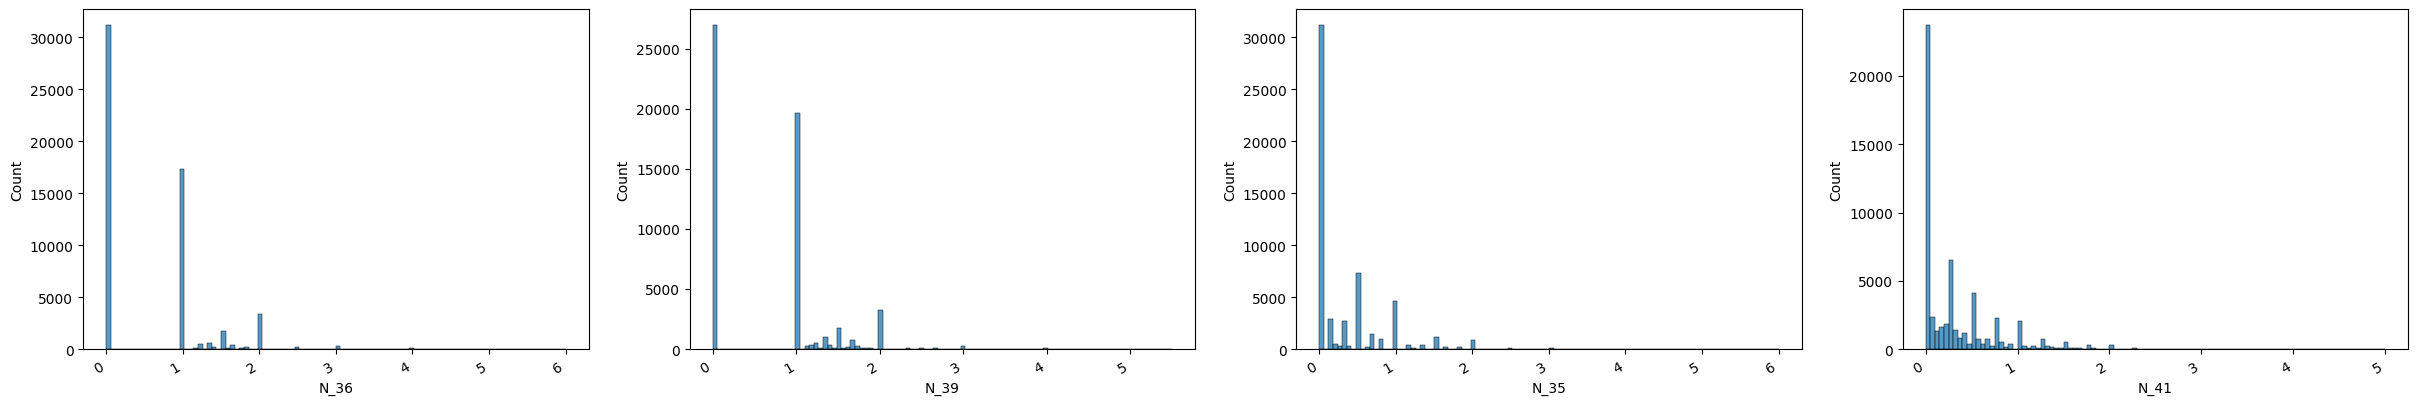

In [ ]:
# графики N_36, N_39 и N_35, N_41 попарно похожи    
# объединим эти признаки в одну группы - N_36, N_39 - G_13 и N_35, N_41 - G_14  
# для N_36 и N_39 добавим категориальный признак со значениями 0, 1, 2 для значений 0, 1 и все остальные соответственно  

train_N = ['N_36', 'N_39', 'N_35', 'N_41']  

sns.set_palette(sns.color_palette("tab10"))  

fig, axes = plt.subplots(1, 4, figsize=(30,5), dpi=100)  
fig.autofmt_xdate()

n = 0  

for col in train_N:  
  sns.histplot(train[col], bins=100, ax=axes[n])  
  n = n + 1  

In [ ]:
# корреляция между собой довольно высокая у всех признаков   

train_df = train[['N_36', 'N_39', 'N_35', 'N_41', 'Y']]  

train_df_corr = train_df.corr().style.background_gradient().set_precision(2)  

train_df_corr  

,N_36,N_39,N_35,N_41,Y
N_36,1.00,0.87,0.85,0.74,0.31
N_39,0.87,1.00,0.75,0.76,0.31
N_35,0.85,0.75,1.00,0.88,0.35
N_41,0.74,0.76,0.88,1.00,0.38
Y,0.31,0.31,0.35,0.38,1.00


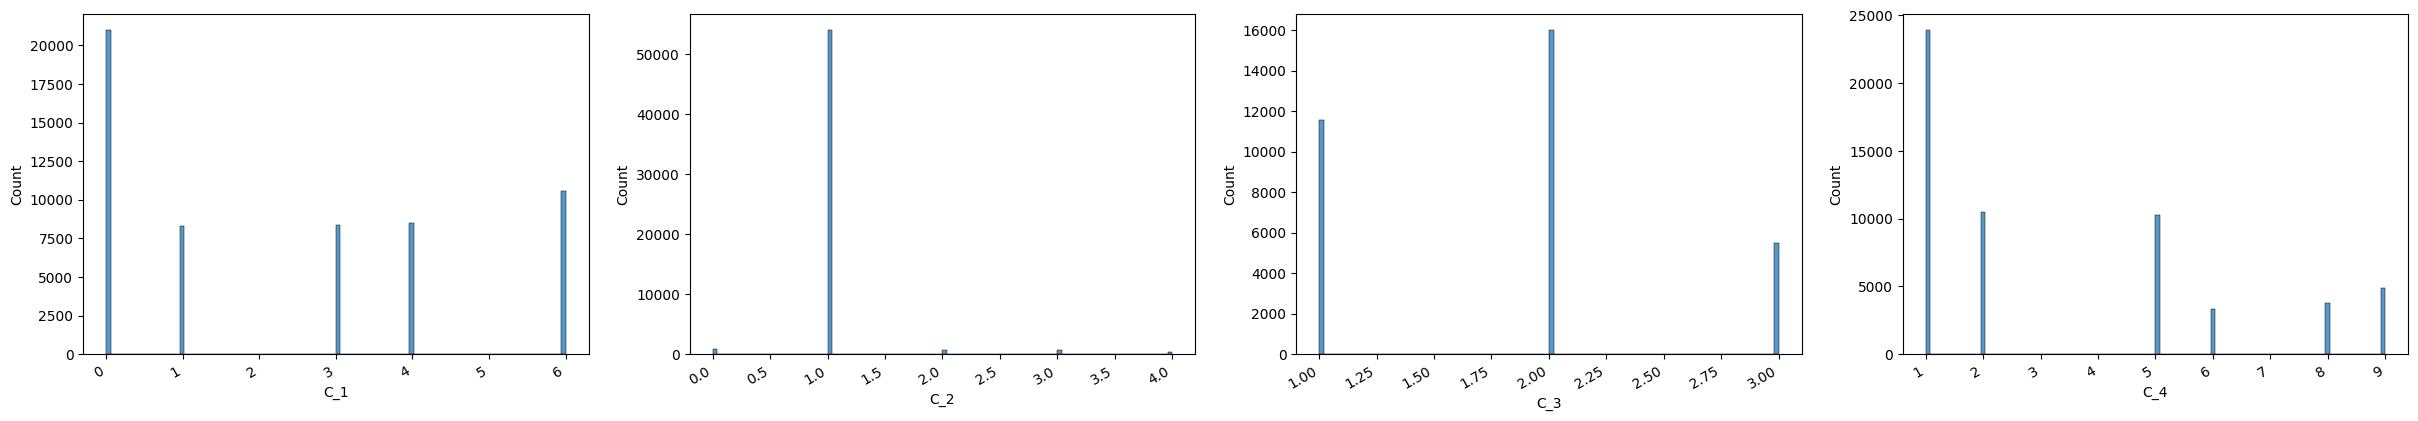

In [ ]:
# посмотрим на распределение  категориальных признаков   

fig, axes = plt.subplots(1, 4, figsize=(30,5), dpi=100)  
fig.autofmt_xdate()

n = 0  

for col in list(train[['C_1', 'C_2', 'C_3', 'C_4']].columns):  
  sns.histplot(train[['C_1', 'C_2', 'C_3', 'C_4']][col], bins=100, ax=axes[n])  
  n = n + 1  

In [ ]:
# у признака C_2 95% содержит одно и то же значение, данный признак неинформативен и его можно удалить    

train['C_2'].value_counts()  

1    53999
0      833
3      784
2      656
4      420
Name: C_2, dtype: int64

In [ ]:
print(train[['C_1', 'C_3', 'C_4']].apply(lambda col: col.unique()))  

C_1         [6, 3, 1, 0, 4]
C_3    [nan, 1.0, 2.0, 3.0]
C_4      [1, 5, 6, 2, 8, 9]
dtype: object


In [ ]:
test['C_3'].unique()

array([nan,  2.,  1.,  3.])

In [ ]:
# пустые значения в C_3 заменим на 0  

train['C_3'] = train['C_3'].fillna(0)  
test['C_3'] = test['C_3'].fillna(0)  

In [ ]:
# пустые значения в остальных столбцах заменим методом 'bfill'  

train.fillna(method='bfill', axis=0, inplace=True)
test.fillna(method='bfill', axis=0, inplace=True)  

# Добавление и удаление признаков  

In [ ]:
# удалим ненужные столбцы 

train.drop(['N_3', 'N_60', 'N_61', 'N_62', 'N_65', 'N_25', 'N_27', 'N_29', 'N_40', 'N_47', 'C_2', 'year'], axis=1, inplace=True)
test.drop(['N_3', 'N_60', 'N_61', 'N_62', 'N_65', 'N_25', 'N_27', 'N_29', 'N_40', 'N_47', 'C_2', 'year'], axis=1, inplace=True)  

In [ ]:
# посмотрим на корреляцию  всех оставшихся признаков

train_df = train.drop(['ID', 'DT', 'C_1', 'C_3', 'C_4'], axis=1)  

train_df_corr = train_df.corr().style.background_gradient().set_precision(2)  

train_df_corr  

,N_1,N_2,N_4,N_5,N_6,N_7,N_8,N_9,N_10,N_11,N_12,N_13,N_14,N_15,N_16,N_17,N_18,N_19,N_20,N_21,N_22,N_23,N_24,N_26,N_28,N_30,N_31,N_32,N_33,N_34,N_35,N_36,N_37,N_38,N_39,N_41,N_42,N_43,N_44,N_45,N_46,N_48,N_49,N_50,N_51,N_52,N_53,N_54,N_55,N_56,N_57,N_58,N_59,N_63,N_64,N_66,N_67,N_68,N_69,N_70,N_71,N_72,N_73,N_74,N_75,N_76,N_77,N_78,N_79,N_80,N_81,N_82,Y,month,day,hour
N_1,1.00,0.34,-0.01,-0.00,-0.02,-0.02,-0.02,-0.02,-0.01,-0.01,-0.02,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.01,-0.02,-0.02,-0.02,-0.02,-0.01,-0.01,-0.01,0.01,-0.01,-0.02,-0.00,-0.01,-0.01,-0.01,-0.01,-0.01,-0.00,-0.01,-0.00,-0.01,-0.01,-0.00,-0.00,-0.01,-0.01,-0.00,-0.01,0.00,-0.00,-0.01,-0.01,-0.01,-0.02,-0.00,-0.00,-0.01,-0.01,-0.00,0.01,0.01,-0.02,-0.00,-0.01,-0.00,-0.00,0.01,0.01,-0.00,-0.01,-0.01,-0.01,0.00,-0.00,0.00,-0.01,-0.01,-0.05,0.02
N_2,0.34,1.00,-0.00,-0.00,-0.00,-0.02,-0.02,-0.01,-0.02,0.00,-0.02,-0.01,-0.01,-0.00,-0.01,-0.00,-0.00,-0.00,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.00,-0.01,-0.01,0.00,-0.01,-0.02,-0.01,-0.02,-0.02,-0.01,-0.02,-0.01,-0.02,-0.02,-0.01,-0.02,-0.02,-0.01,-0.01,-0.02,0.00,0.00,-0.00,-0.00,-0.01,-0.01,0.01,0.01,-0.02,-0.02,-0.02,-0.00,0.02,-0.01,-0.01,-0.01,-0.01,-0.01,0.00,0.01,0.00,-0.01,-0.01,-0.01,0.01,-0.00,-0.00,-0.02,-0.01,-0.10,-0.00
N_4,-0.01,-0.00,1.00,0.43,0.33,0.34,0.34,0.37,0.38,0.56,0.37,0.44,0.37,0.44,0.35,0.44,0.86,0.78,0.74,0.71,0.70,0.65,0.48,0.46,0.44,0.20,0.42,0.59,0.19,0.42,0.52,0.45,0.41,0.53,0.44,0.54,0.43,0.43,0.55,0.08,0.41,0.55,0.12,0.40,0.45,0.13,0.11,0.16,0.40,0.21,0.45,-0.14,-0.21,0.34,0.26,0.20,-0.03,-0.31,0.16,0.14,0.27,0.26,0.15,0.06,-0.36,-0.06,0.05,-0.07,0.33,-0.26,0.01,0.07,0.30,-0.00,0.02,-0.29
N_5,-0.00,-0.00,0.43,1.00,0.37,0.29,0.28,0.32,0.33,0.07,0.33,0.37,0.32,0.37,0.31,0.35,0.83,0.78,0.72,0.68,0.66,0.60,0.45,0.42,0.40,0.21,0.39,0.54,0.21,0.38,0.44,0.38,0.34,0.45,0.37,0.46,0.36,0.36,0.46,0.08,0.35,0.46,0.11,0.35,0.37,0.14,0.12,0.17,0.40,0.23,0.45,-0.13,-0.19,0.31,0.19,0.15,-0.01,-0.25,0.16,0.12,0.21,0.20,0.14,0.04,-0.30,-0.05,0.04,-0.04,0.27,-0.22,-0.01,0.05,0.25,0.01,0.02,-0.25
N_6,-0.02,-0.00,0.33,0.37,1.00,0.40,0.30,0.32,0.35,0.02,0.31,0.31,0.30,0.31,0.30,0.29,0.42,0.73,0.72,0.69,0.67,0.61,0.44,0.41,0.40,0.19,0.38,0.55,0.19,0.38,0.42,0.35,0.32,0.43,0.35,0.44,0.35,0.34,0.45,0.07,0.34,0.44,0.10,0.33,0.35,0.12,0.10,0.16,0.41,0.23,0.45,-0.12,-0.17,0.30,0.19,0.15,-0.01,-0.24,0.16,0.12,0.21,0.20,0.13,0.05,-0.31,-0.05,0.05,-0.05,0.26,-0.21,-0.01,0.05,0.25,0.01,0.01,-0.26
N_7,-0.02,-0.02,0.34,0.29,0.40,1.00,0.41,0.36,0.36,0.02,0.33,0.31,0.31,0.30,0.32,0.29,0.37,0.45,0.70,0.70,0.68,0.63,0.44,0.42,0.40,0.19,0.39,0.56,0.19,0.39,0.44,0.37,0.33,0.45,0.36,0.46,0.36,0.36,0.47,0.07,0.35,0.47,0.11,0.35,0.37,0.12,0.10,0.16,0.40,0.24,0.45,-0.11,-0.18,0.31,0.20,0.16,-0.02,-0.26,0.16,0.12,0.22,0.22,0.13,0.05,-0.32,-0.05,0.05,-0.05,0.28,-0.22,-0.00,0.05,0.26,0.01,0.01,-0.26
N_8,-0.02,-0.02,0.34,0.28,0.30,0.41,1.00,0.44,0.39,0.03,0.34,0.31,0.34,0.30,0.32,0.29,0.37,0.40,0.46,0.67,0.68,0.63,0.44,0.42,0.40,0.19,0.39,0.56,0.15,0.39,0.48,0.41,0.37,0.49,0.40,0.49,0.39,0.38,0.49,0.10,0.36,0.49,0.10,0.36,0.39,0.12,0.09,0.16,0.39,0.24,0.44,-0.11,-0.19,0.32,0.21,0.17,-0.01,-0.27,0.15,0.11,0.23,0.22,0.13,0.05,-0.32,-0.05,0.03,-0.06,0.29,-0.23,0.02,0.06,0.26,0.01,0.02,-0.26
N_9,-0.02,-0.01,0.37,0.32,0.32,0.36,0.44,1.00,0.44,0.01,0.39,0.35,0.37,0.34,0.35,0.33,0.41,0.44,0.48,0.52,0.69,0.66,0.46,0.43,0.42,0.23,0.40,0.58,0.17,0.39,0.55,0.47,0.44,0.56,0.44,0.56,0.43,0.45,0.55,0.13,0.40,0.54,0.14,0.39,0.45,0.07,0.07,0.12,0.40,0.22,0.45,-0.12,-0.21,0.33,0.27,0.22,-0.00,-0.32,0.14,0.12,0.25,0.25,0.14,0.05,-0.34,-0.05,0.04,-0.07,0.32,-0.25,0.03,0.08,0.29,0.02,0.02,-0.28
N_10,-0.01,-0.02,0.38,0.33,0.35,0.36,0.39,0.44,1.00,-0.01,0.45,0.37,0.42,0.35,0.39,0.34,0.42,0.46,0.49,0.52,0.55,0.67,0.49,0.45,0.44,0.22,0.41,0.59,0.19,0.41,0.77,0.67,0.66,0.73,0.61,0.70,0.57,0.60,0.65,0.27,0.50,0.63,0.22,0.47,0.55,-0.33,-0.23,-0.21,0.24,-0.06,0.33,-0.13,-0.27,0.35,0.31,0.28,0.03,-0.38,0.14,0.13,0.26,0.25,0.13,0.04,-0.33,-0.05,0.03,-0.08,0.36,

In [ ]:
# видим несколько признаков с корреляцией 95% и выше  
# оставим признаки с наибольшей корреляцией корреляцией с целевой переменной, удалим N_20, N_21, N_38, N_44  

train_df = train[['N_20', 'N_21', 'N_22', 'N_38', 'N_41', 'N_44', 'N_48', 'Y']]  

train_df_corr = train_df.corr().style.background_gradient().set_precision(2)  

train_df_corr  

,N_20,N_21,N_22,N_38,N_41,N_44,N_48,Y
N_20,1.00,0.97,0.94,0.65,0.66,0.67,0.66,0.37
N_21,0.97,1.00,0.98,0.68,0.69,0.70,0.70,0.38
N_22,0.94,0.98,1.00,0.71,0.72,0.73,0.72,0.40
N_38,0.65,0.68,0.71,1.00,0.96,0.90,0.86,0.39
N_41,0.66,0.69,0.72,0.96,1.00,0.94,0.90,0.40
N_44,0.67,0.70,0.73,0.90,0.94,1.00,0.97,0.41
N_48,0.66,0.70,0.72,0.86,0.90,0.97,1.00,0.42
Y,0.37,0.38,0.40,0.39,0.40,0.41,0.42,1.00


In [ ]:
train.drop(['N_20', 'N_21', 'N_38', 'N_44'], axis=1, inplace=True)
test.drop(['N_20', 'N_21', 'N_38', 'N_44'], axis=1, inplace=True)  

In [ ]:
# посмотрим на признаки с корреляией больше 0.9  

train_df = train.drop(['ID', 'DT', 'C_1', 'C_3', 'C_4'], axis=1)  

t_corr = train_df.corr().abs()
t_corr = t_corr.unstack()  
t_corr = t_corr.reset_index()  
t_corr.columns = ['f1', 'f2', 'corr_value']  

t_corr_9 = t_corr[(t_corr.f1 != t_corr.f2) & (t_corr.corr_value >= 0.9)].sort_values(by='corr_value', ascending=False)  
t_corr_9.loc[::2]  

,f1,f2,corr_value
3776,N_66,N_68,0.949870
2741,N_48,N_51,0.924498
1333,N_22,N_23,0.914163
2370,N_41,N_43,0.913718
1779,N_31,N_34,0.912245
1185,N_18,N_19,0.910115
2074,N_35,N_37,0.904198
2296,N_39,N_42,0.901042


In [ ]:
train[['N_66', 'N_68', 'N_48', 'N_51', 'N_22', 'N_23', 'N_41', 'N_43', 'N_31', 'N_34', 'N_18', 'N_19', 'N_35', 'N_37', 'N_39', 'N_42']].head()  

,N_66,N_68,N_48,N_51,N_22,N_23,N_41,N_43,N_31,N_34,N_18,N_19,N_35,N_37,N_39,N_42
0,0.0400,0.9600,0.0526,0.0526,0.0000,0.0714,0.2500,0.2500,1.0,1.0000,0.0,0.0000,0.5000,0.5000,1.0,1.0
1,0.0588,0.9412,0.1667,0.0833,0.0000,0.0000,0.0000,0.0000,1.0,1.6667,0.0,0.0000,0.0000,0.0000,0.0,0.0
2,0.3333,0.6667,0.3333,0.1667,0.1667,0.2143,1.0000,0.5000,1.5,1.4375,0.5,0.3333,1.0000,0.5000,2.0,2.0
3,0.0426,0.9574,0.0811,0.0541,0.3333,0.1429,0.1538,0.0769,1.5,1.5000,1.0,0.6667,0.3333,0.1667,2.0,2.0
4,0.8298,0.1277,0.8108,0.8108,0.6667,0.6429,0.9286,0.9286,1.0,1.0000,1.0,1.0000,1.0000,1.0000,1.0,1.0


In [ ]:
# посмотрим на признаки с корреляией больше 0.8  

train_df = train.drop(['ID', 'DT', 'C_1', 'C_3', 'C_4'], axis=1)  

t_corr = train_df.corr().abs()
t_corr = t_corr.unstack()  
t_corr = t_corr.reset_index()  
t_corr.columns = ['f1', 'f2', 'corr_value']  

t_corr_8 = t_corr[(t_corr.f1 != t_corr.f2) & (t_corr.corr_value >= 0.8) & (t_corr.corr_value < 0.9)].sort_values(by='corr_value', ascending=False)  
t_corr_8.loc[::2]  

,f1,f2,corr_value
2373,N_41,N_48,0.899964
1555,N_26,N_28,0.898743
2883,N_50,N_46,0.892261
2726,N_48,N_32,0.890288
2364,N_41,N_35,0.883931
1844,N_32,N_23,0.883029
1481,N_24,N_26,0.882239
2522,N_43,N_51,0.877460
2148,N_36,N_39,0.873682
2512,N_43,N_37,0.868263


In [ ]:
#  осталось 66 пар признаков с выскокой корреляцией, для них создадим новые признаки на основе деления одного признака на другой    

len(t_corr_9) + len(t_corr_8)

66

In [ ]:
#  исходные признаки удалим, всего таких признаков  32  

corr_feat = []  
corr_feat = corr_feat + [t_corr_9.f1.values] + [t_corr_9.f2.values] + [t_corr_8.f1.values] + [t_corr_8.f2.values]  

l = []

for i in corr_feat:  
  for j in i:  
    l.append(j)  

l_unique = set(l)  

len(set(l))  

32

In [ ]:
# признаков, скошенных, в ноль - 3, для них также добавим новые признаки  

max_df = pd.DataFrame(columns=('col', 'value', 'count'))  

for i in cols:  
  g = train.groupby([i])[i].count()  
  g_df = pd.DataFrame({'col': i, 'value': g.index, 'count': g})  
  g_df = g_df[g_df['count'] == g_df['count'].max()][['col', 'value', 'count']]

  max_df = pd.concat([max_df, g_df], axis=0)  

max_df['%'] = max_df['count'] / 60000 * 100  

max_df[max_df['%'] > 60]  

,col,value,count,%
0.0,N_11,0,44262,73.77
0.0,N_12,0,44358,73.93
0.0,N_18,0.0,38460,64.1
0.0,N_63,0.0,44186,73.643333
1.0,N_77,1,42237,70.395


In [ ]:
# добавим категориальные признаки для скошенных данных  

for i in train[['N_1', 'N_2', 'N_4', 'N_5', 'N_6', 'N_7', 'N_8', 'N_9', 'N_10', 'N_11', 'N_12', 
                     'N_13', 'N_14', 'N_15', 'N_16', 'N_17', 'N_18', 'N_37', 'N_43', 'N_51', 'N_63', 
                     'N_69', 'N_70', 'N_71', 'N_72', 'N_73', 'N_74', 'N_79']].columns:  
  train[i+'_b'] = train[train[i] == 0][i]  
  train[i+'_b'] = train[i+'_b'].replace(to_replace=[0, np.nan], value=[1, 0])  
  train[i+'_b'] = train[i+'_b'].astype('int64')  

for i in test[['N_1', 'N_2', 'N_4', 'N_5', 'N_6', 'N_7', 'N_8', 'N_9', 'N_10', 'N_11', 'N_12', 
                     'N_13', 'N_14', 'N_15', 'N_16', 'N_17', 'N_18', 'N_37', 'N_43', 'N_51', 'N_63', 
                     'N_69', 'N_70', 'N_71', 'N_72', 'N_73', 'N_74', 'N_79']].columns:  
  test[i+'_b'] = test[test[i] == 0][i]  
  test[i+'_b'] = test[i+'_b'].replace(to_replace=[0, np.nan], value=[1, 0])  
  test[i+'_b'] = test[i+'_b'].astype('int64')  

for i in train[['N_75', 'N_77', 'N_80']].columns:  
  train[i+'_b'] = train[train[i] == 1][i]  
  train[i+'_b'] = train[i+'_b'].replace(to_replace=[1, np.nan], value=[1, 0])  
  train[i+'_b'] = train[i+'_b'].astype('int64')  

for i in test[['N_75', 'N_77', 'N_80']].columns:  
  test[i+'_b'] = test[test[i] == 1][i]  
  test[i+'_b'] = test[i+'_b'].replace(to_replace=[1, np.nan], value=[1, 0])  
  test[i+'_b'] = test[i+'_b'].astype('int64')  

In [ ]:
# добавим категориальные признаки для данных, скошенных в 0 и 1 одновременно    

for i in train[['N_24', 'N_26', 'N_28', 'N_31', 'N_34', 'N_46', 'N_50', 'N_36', 'N_39']].columns:  
  train[i+'_b'] = np.where(train[i] > 1, 2, train[i])  
  train[i+'_b'] = train[i+'_b'].astype('int64')  

for i in test[['N_24', 'N_26', 'N_28', 'N_31', 'N_34', 'N_46', 'N_50', 'N_36', 'N_39']].columns:  
  test[i+'_b'] = np.where(test[i] > 1, 2, test[i])  
  test[i+'_b'] = test[i+'_b'].astype('int64')  

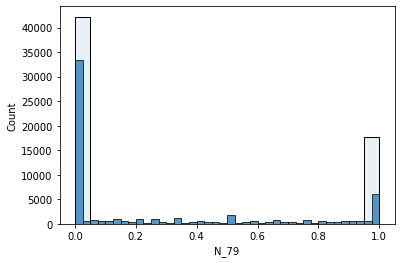

In [ ]:
# наиболее высокая корреляция с целевой переменной у признака N_79, как видно из графика распределения действительно похожи, но у N_79 между 0 и 1 есть множество других значений  

sns.histplot(train.N_79)  
sns.histplot(train.Y, alpha=0.1);  

In [ ]:
# добавим для него категориальный признак  

train['N_79_b'] = np.where((train['N_79'] > 0) & (train['N_79'] < 1), 2, train['N_79'])  
train['N_79_b'] = train['N_79_b'].astype('int64')  

test['N_79_b'] = np.where((test['N_79'] > 0) & (test['N_79'] < 1), 2, test['N_79'])  
test['N_79_b'] = test['N_79_b'].astype('int64')  

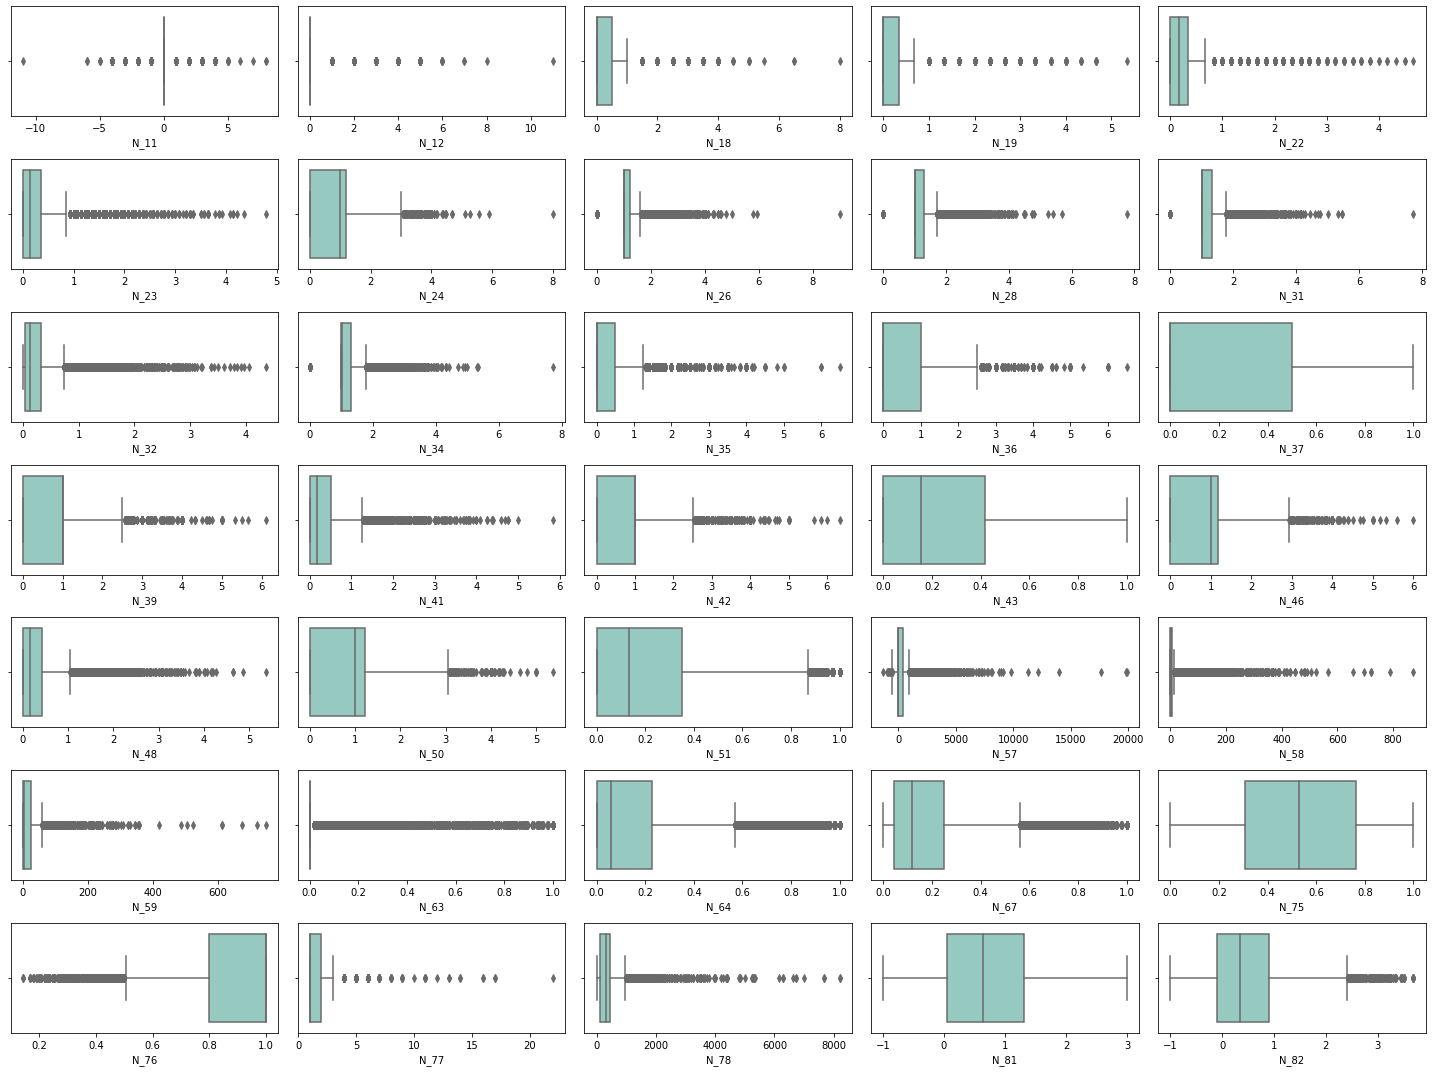

In [ ]:
# у части признаков есть выбросы, удалим их  

rows = 7  
cols_num = 5  
c = 1  

fig = plt.figure(figsize=(20,15))

for i in cols:
    plt.subplot(rows, cols_num, c)  
    sns.boxplot(train[i], palette='Set3')  
    c = c + 1  
    plt.tight_layout()  

In [ ]:
train = train[(train.N_11 > -10) & (train.N_12 < 10) & (train.N_24 < 8) & (train.N_26 < 8) & (train.N_28 < 7) & 
              (train.N_31 < 7) & (train.N_34 < 7) & (train.N_41 < 5.5) & (train.N_77 < 20)]  

In [ ]:
# добавим новые признаки на основе выделенных ранее групп: минимальное, максимальное, среднее,  разницу между мин и макс значениями  

G_1 = ['N_1', 'N_2']  
G_2 = ['N_79', 'N_80']  
G_3 = ['N_30', 'N_33', 'N_45', 'N_49', 'N_52', 'N_53', 'N_54', 'N_55', 'N_56']  
G_4 = ['N_69', 'N_70', 'N_71', 'N_72', 'N_73', 'N_74']  
G_5 = ['N_66', 'N_68']  
G_6 = ['N_9', 'N_10', 'N_14']  
G_7 = ['N_6', 'N_7', 'N_13', 'N_15', 'N_17']  
G_8 = ['N_4', 'N_5']  
G_9 = ['N_8', 'N_16']
G_10 = ['N_81', 'N_82']  
G_11 = ['N_19', 'N_22', 'N_23', 'N_32']  
G_12 = ['N_12', 'N_24', 'N_26', 'N_28', 'N_31', 'N_34', 'N_46', 'N_50']  
G_13 = ['N_36', 'N_39']  
G_14 = ['N_35', 'N_34']  

g_cols = list([G_1, G_2, G_3, G_4, G_5, G_6, G_7, G_8, G_9, G_10, G_11, G_12, G_13, G_14])
g_names = list(['G_1', 'G_2', 'G_3', 'G_4', 'G_5', 'G_6', 'G_7', 'G_8', 'G_9', 'G_10', 'G_11', 'G_12', 'G_13', 'G_14'])  

n = 0  

for i in g_cols:  
  train[g_names[n]+'_mean'] = train[i].mean(axis=1)  
  train[g_names[n]+'_max'] = train[i].max(axis=1)  
  train[g_names[n]+'_min'] = train[i].min(axis=1)  
  train[g_names[n]+'_diff'] = train[i].max(axis=1) - train[i].min(axis=1)  
  n += 1  

n = 0 

for i in g_cols:  
  test[g_names[n]+'_mean'] = test[i].mean(axis=1)  
  test[g_names[n]+'_max'] = test[i].max(axis=1)  
  test[g_names[n]+'_min'] = test[i].min(axis=1)  
  test[g_names[n]+'_diff'] = test[i].max(axis=1) - test[i].min(axis=1)  
  n += 1


# Работа с временными признаками  

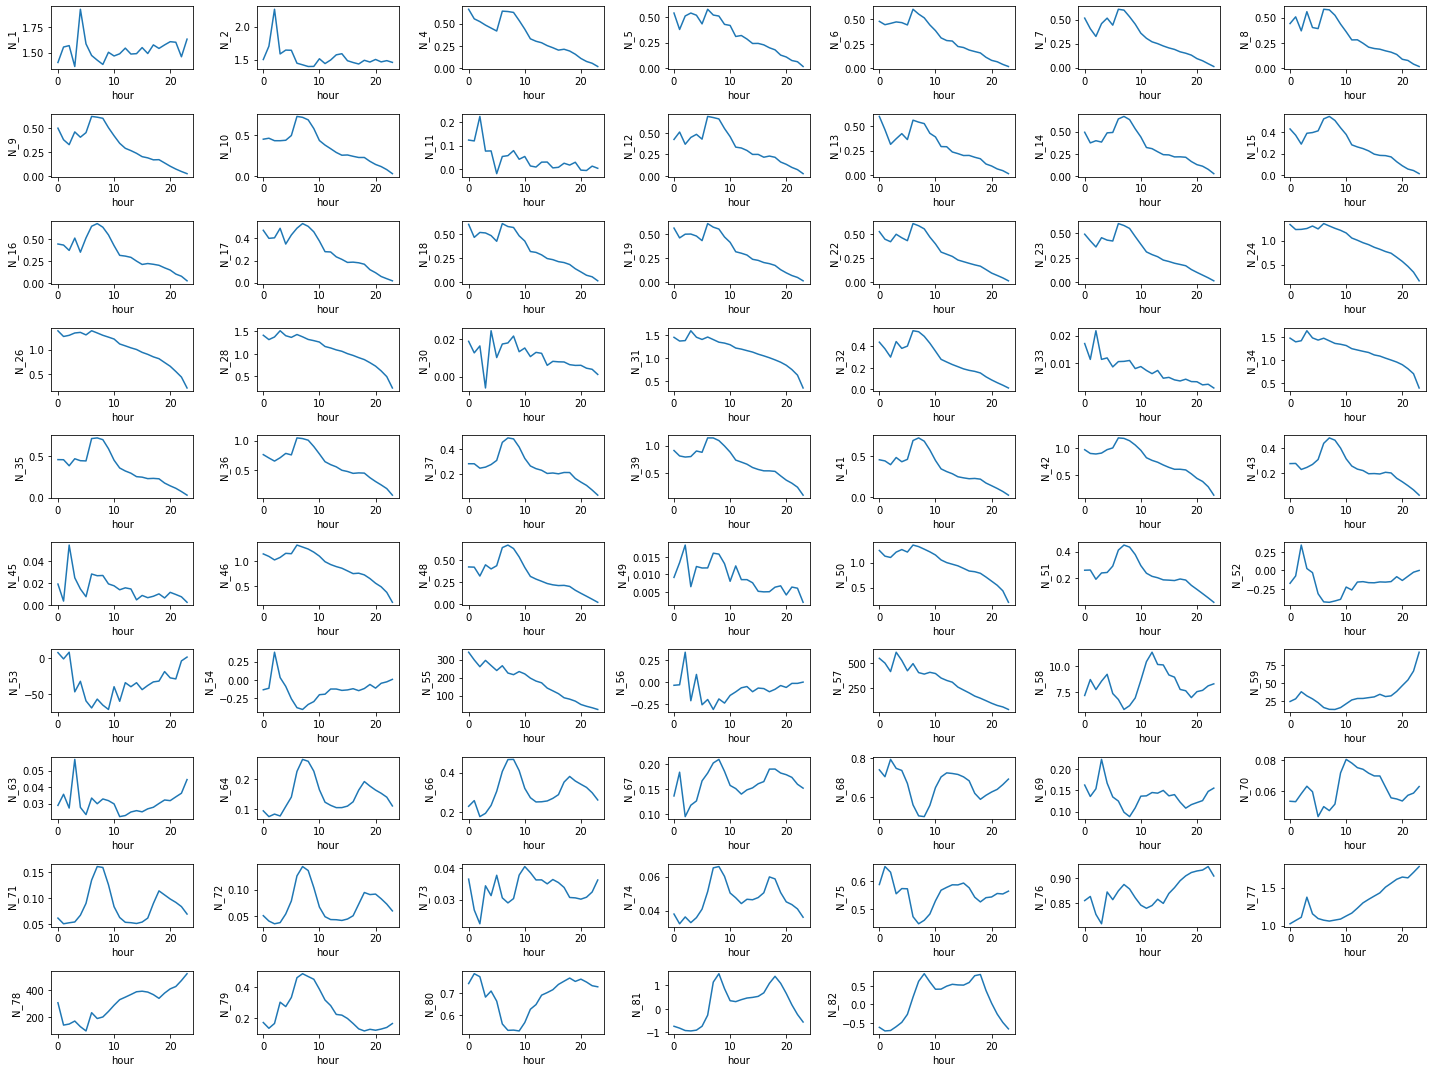

In [ ]:
# у всех признаков есть зависимость от часа дня, добавим средние показатели по часам для каждого  признака   

cols = train.filter(like="N_").columns  

rows = 10  
cols_num = 7  
c = 1  

fig = plt.figure(figsize=(20,15))

for i in cols:
    plt.subplot(rows, cols_num, c)  
    a = train.groupby(['hour'], as_index=False)[i].mean()  
    sns.lineplot(x=a['hour'], y=a[i])  
    c = c + 1  
    plt.tight_layout()  

In [ ]:
# у всех признаков есть зависимость от часа дня, по паттернам можно выделить 9 групп, добавим средние показатели по часам для каждой группы  

cols = train.filter(like="N_").columns  

a = train.groupby(['hour'], as_index=False)['N_1'].mean()  

for i in cols:
    b = train.groupby(['hour'], as_index=False)[i].mean()  
    a = a.merge(b, how='left', on='hour')   

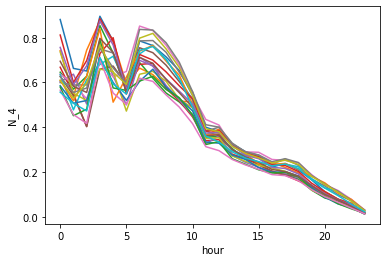

In [ ]:
H_1 = ['N_4', 'N_5', 'N_6', 'N_7', 'N_8', 'N_9', 'N_10', 'N_12', 'N_13', 'N_14', 'N_15', 
       'N_16', 'N_17', 'N_18', 'N_19', 'N_22', 'N_32', 'N_35', 'N_41', 'N_48']  

for i in H_1:
    sns.lineplot(x=a['hour'], y=a[i])  

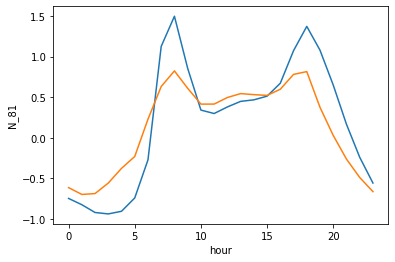

In [ ]:
H_2 = ['N_81', 'N_82']  

for i in H_2:
    sns.lineplot(x=a['hour'], y=a[i])  

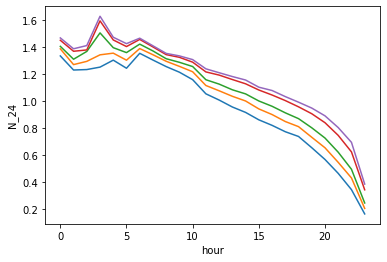

In [ ]:
H_3 = ['N_24', 'N_26', 'N_28', 'N_31', 'N_34']  

for i in H_3:
    sns.lineplot(x=a['hour'], y=a[i])  

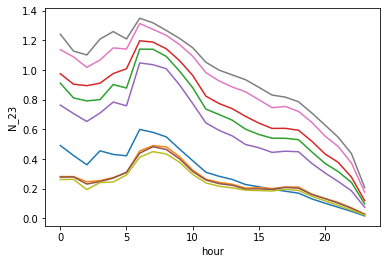

In [ ]:
H_4 = ['N_23', 'N_37', 'N_39', 'N_42', 'N_36', 'N_43', 'N_46', 'N_50', 'N_51']  

for i in H_4:
    sns.lineplot(x=a['hour'], y=a[i])  

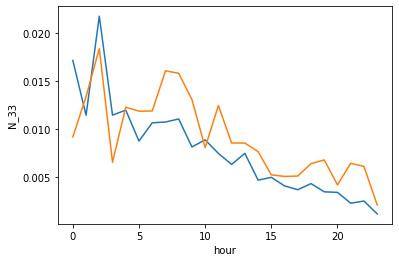

In [ ]:
H_5 = ['N_33', 'N_49']  

for i in H_5:
    sns.lineplot(x=a['hour'], y=a[i])  

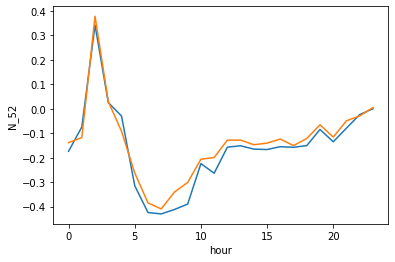

In [ ]:
H_6 = ['N_52', 'N_54']  

for i in H_6:
    sns.lineplot(x=a['hour'], y=a[i])   

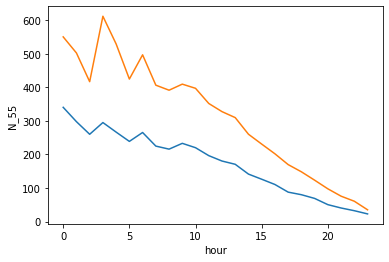

In [ ]:
H_7 = ['N_55', 'N_57']  

for i in H_7:
    sns.lineplot(x=a['hour'], y=a[i])   

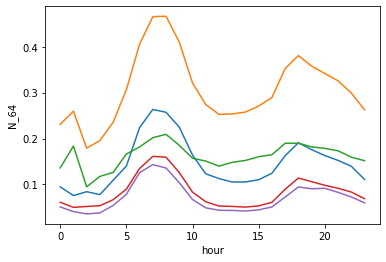

In [ ]:
H_8 = ['N_64', 'N_66', 'N_67', 'N_71', 'N_72']  

for i in H_8:
    sns.lineplot(x=a['hour'], y=a[i])  

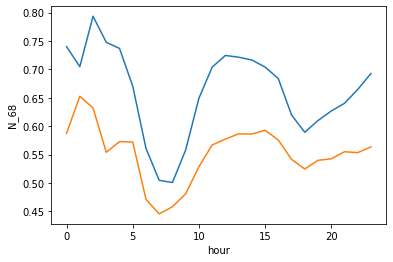

In [ ]:
H_9 = ['N_68', 'N_75']  

for i in H_9:
    sns.lineplot(x=a['hour'], y=a[i])  

In [ ]:
h_cols = list([H_1, H_2, H_3, H_4, H_5, H_6, H_7, H_8, H_9])
h_names = list(['H_1', 'H_2', 'H_3', 'H_4', 'H_5', 'H_6', 'H_7', 'H_8', 'H_9'])  

b = pd.DataFrame(data={'hour': a.hour})
n = 0  

for i in h_cols:  
  b[h_names[n]+'_mean'] = a[i].mean(axis=1)  
  n += 1  

train = train.merge(b, how='left', on='hour')  

In [ ]:
cols = test.filter(like="N_").columns  

a = test.groupby(['hour'], as_index=False)['N_1'].mean()  

for i in cols:
    b = test.groupby(['hour'], as_index=False)[i].mean()  
    a = a.merge(b, how='left', on='hour')   

b = pd.DataFrame(data={'hour': a.hour})
n = 0  

for i in h_cols:  
  b[h_names[n]+'_mean'] = a[i].mean(axis=1)  
  n += 1  

test = test.merge(b, how='left', on='hour')  

In [ ]:
# у всех признаков есть зависимость от месяца, по паттернам можно выделить 9 групп, добавим средние показатели по месяцам для каждой группы  

cols = train.filter(like="N_").columns  

a = train.groupby(['month'], as_index=False)['N_1'].mean()  

for i in cols:
    b = train.groupby(['month'], as_index=False)[i].mean()  
    a = a.merge(b, how='left', on='month')   

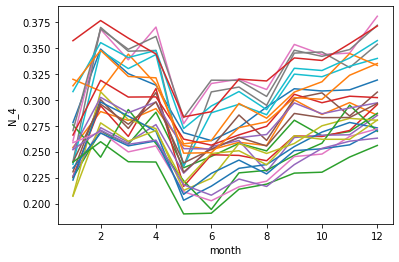

In [ ]:
M_1 = ['N_4', 'N_5', 'N_6', 'N_7', 'N_8', 'N_9', 'N_10', 'N_12', 'N_13', 'N_14', 'N_15', 'N_16', 'N_17', 
        'N_18', 'N_19', 'N_22', 'N_32', 'N_35', 'N_37', 'N_41', 'N_43', 'N_48', 'N_51', 'N_66', 'N_79']  

for i in M_1:
    sns.lineplot(x=a['month'], y=a[i])  

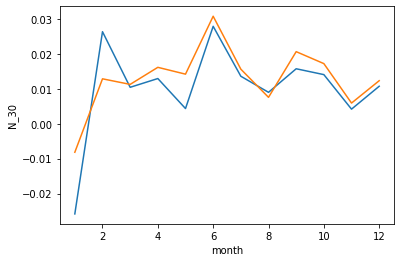

In [ ]:
M_2 = ['N_30', 'N_45']  

for i in M_2:
    sns.lineplot(x=a['month'], y=a[i])  

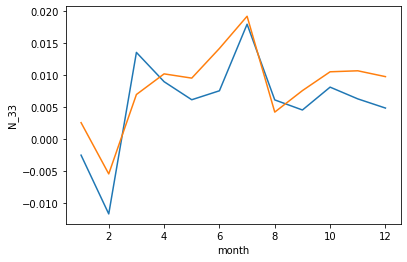

In [ ]:
M_3 = ['N_33', 'N_49']  

for i in M_3:
    sns.lineplot(x=a['month'], y=a[i])   

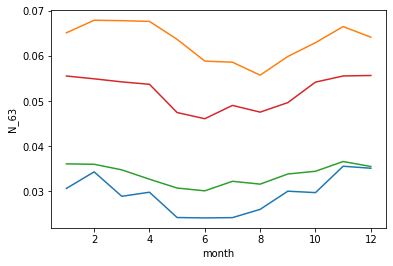

In [ ]:
M_4 = ['N_63', 'N_70', 'N_73', 'N_74']  

for i in M_4:
    sns.lineplot(x=a['month'], y=a[i])   

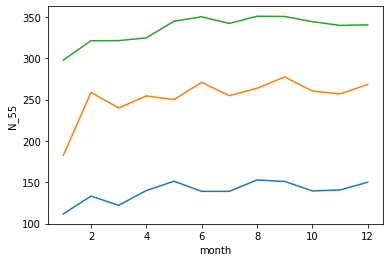

In [ ]:
M_5 = ['N_55', 'N_57', 'N_78']  

for i in M_5:
    sns.lineplot(x=a['month'], y=a[i])  

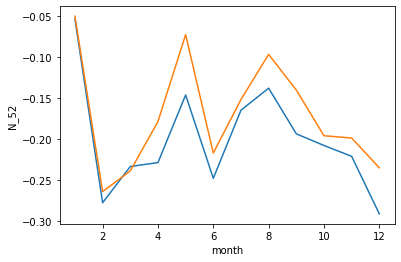

In [ ]:
M_6 = ['N_52', 'N_54']  

for i in M_6:
    sns.lineplot(x=a['month'], y=a[i])  

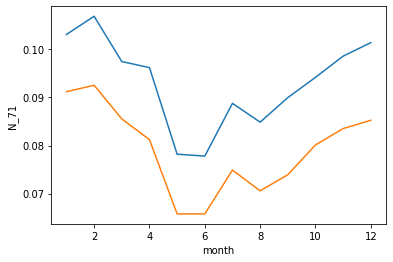

In [ ]:
M_7 = ['N_71', 'N_72']  

for i in M_7:
    sns.lineplot(x=a['month'], y=a[i])  

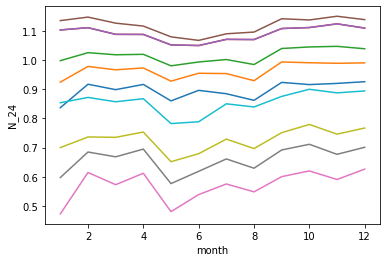

In [ ]:
M_8 = ['N_24', 'N_26', 'N_28', 'N_31', 'N_31', 'N_34', 'N_36', 'N_39', 'N_42', 'N_46']

for i in M_8:
    sns.lineplot(x=a['month'], y=a[i])  

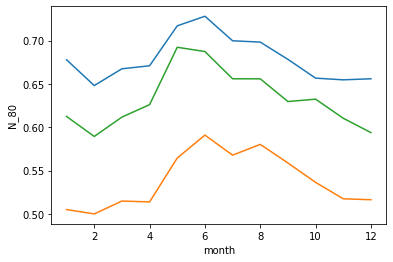

In [ ]:
M_9 = ['N_80', 'N_75', 'N_68']

for i in M_9:
    sns.lineplot(x=a['month'], y=a[i])  

In [ ]:
m_cols = list([M_1, M_2, M_3, M_4, M_5, M_6, M_7, M_8, M_9])
m_names = list(['M_1', 'M_2', 'M_3', 'M_4', 'M_5', 'M_6', 'M_7', 'M_8', 'M_9'])  

b = pd.DataFrame(data={'month': a.month})
n = 0  

for i in m_cols:  
  b[m_names[n]+'_mean'] = a[i].mean(axis=1)  
  n += 1  

train = train.merge(b, how='left', on='month')  

In [ ]:
cols = test.filter(like="N_").columns  

a = test.groupby(['month'], as_index=False)['N_1'].mean()  

for i in cols:
    b = test.groupby(['month'], as_index=False)[i].mean()  
    a = a.merge(b, how='left', on='month')   

b = pd.DataFrame(data={'month': a.month})
n = 0  

for i in m_cols:  
  b[m_names[n]+'_mean'] = a[i].mean(axis=1)  
  n += 1  

test = test.merge(b, how='left', on='month')  

# Дополнительные признаки  

In [ ]:
# добавим дополнительные признаки на основе средних значений целевой переменной  

cols = ['N_1', 'N_2', 'N_4', 'N_5', 'N_6', 'N_7', 'N_8', 'N_9', 'N_10', 'N_11', 'N_12', 'N_13', 'N_14', 'N_15', 
        'N_16', 'N_17', 'N_18', 'N_19', 'N_22', 'N_23', 'N_35', 'N_36', 'N_37', 'N_43', 'N_52', 'N_54', 'N_77']    

for i in cols:  
  train[i+'_Y_mean'] = train.groupby(i)['Y'].transform('mean').astype(np.float16)  
  a = train[i]  
  a = pd.concat([a, train[i+'_Y_mean']], axis=1)  
  a.drop_duplicates(inplace=True)  
  test = test.merge(a, how='left', on=i)


In [ ]:
a = train.filter(like='N_').apply(lambda x: x.nunique()).reset_index()  
a[(a[0] < 150) & (a[0] > 3)]  

,index,0
0,N_1,54
1,N_2,54
2,N_4,20
3,N_5,19
4,N_6,17
5,N_7,20
6,N_8,16
7,N_9,21
8,N_10,20
9,N_11,27


In [ ]:
# добавим дополнительные признаки на основе средних значений признаков N по всем трем категориальным признакам  C    

cols = ['N_1', 'N_2', 'N_4', 'N_5', 'N_6', 'N_7', 'N_8', 'N_9', 'N_10', 'N_11', 'N_12', 'N_13', 'N_14', 'N_15', 
        'N_16', 'N_17', 'N_18', 'N_19', 'N_22', 'N_23', 'N_35', 'N_36', 'N_37', 'N_43', 'N_52', 'N_54', 'N_77']        

for i in cols:  
  train[i+'_C_mean'] = train.groupby(['C_1', 'C_3', 'C_4'])[i].transform('mean').astype(np.float16)  

for i in cols:  
  test[i+'_C_mean'] = test.groupby(['C_1', 'C_3', 'C_4'])[i].transform('mean').astype(np.float16)  

In [ ]:
test.isna().sum()

ID              0
DT              0
N_1             0
N_2             0
N_4             0
               ..
N_37_Y_mean     0
N_43_Y_mean     0
N_52_Y_mean    16
N_54_Y_mean    16
N_77_Y_mean     4
Length: 243, dtype: int64

In [ ]:
test.fillna(0, inplace=True)

# Работа с признаками с высокой корреляцией  

In [ ]:
# добавим новые признаки на основе корреляции  и удалим исходные  

l = []  
for i in t_corr_9.loc[::2][['f1', 'f2']].values:  
   l.append([i])  

n = 0  
for i in range(len(l)):  
  train['corr1_'+l[n][0][0]] = train[l[n][0][0]] / train[l[n][0][1]]  
  test['corr1_'+l[n][0][0]] = test[l[n][0][0]] / test[l[n][0][1]]  
  n += 1

l = []  
for i in t_corr_8.loc[::2][['f1', 'f2']].values:  
   l.append([i])  

n = 0  
for i in range(len(l)):  
  train['corr2_'+l[n][0][0]] = train[l[n][0][0]] / train[l[n][0][1]]  
  test['corr2_'+l[n][0][0]] = test[l[n][0][0]] / test[l[n][0][1]]  
  n += 1  

In [ ]:
train = train.drop(list(l_unique), axis=1)  
test = test.drop(list(l_unique), axis=1)  

In [ ]:
train.fillna(0, inplace=True)  
test.fillna(0, inplace=True)  

In [ ]:
# проверим корреляцию новых признаков и удалим лишние  

t_corr3 = train.filter(like='corr').corr().abs()  

t_corr3 = t_corr3.unstack()  
t_corr3 = t_corr3.reset_index()  
t_corr3.columns = ['f1', 'f2', 'corr_value']  

t_corr_9_3 = t_corr3[(t_corr3.f1 != t_corr3.f2) & (t_corr3.corr_value >= 0.8)].sort_values(by='corr_value', ascending=False)  
t_corr_9_3.loc[::2]  



,f1,f2,corr_value
230,corr2_N_41,corr2_N_43,0.951700
625,corr2_N_31,corr1_N_31,0.947273
177,corr1_N_35,corr2_N_36,0.903280
678,corr2_N_42,corr1_N_41,0.901501
214,corr1_N_39,corr2_N_42,0.871165
37,corr1_N_48,corr2_N_50,0.856381
204,corr1_N_39,corr2_N_36,0.848618
360,corr2_N_24,corr2_N_26,0.831573
501,corr2_N_35,corr2_N_36,0.817966
241,corr2_N_41,corr2_N_42,0.804921


In [ ]:
t_corr3 = train[['corr2_N_41', 'corr2_N_43', 'corr2_N_31', 'corr1_N_31', 'corr1_N_35', 'corr2_N_36', 'corr2_N_42', 
                 'corr1_N_41', 'corr1_N_39', 'corr1_N_48', 'corr2_N_50', 'corr2_N_24', 'corr2_N_26', 'corr2_N_35']].columns  

a = [i for i in t_corr3] 
a = a + ['Y']   

train_df = train[a]  
train_df_corr = train_df.corr().style.background_gradient().set_precision(2)  

train_df_corr  

,corr2_N_41,corr2_N_43,corr2_N_31,corr1_N_31,corr1_N_35,corr2_N_36,corr2_N_42,corr1_N_41,corr1_N_39,corr1_N_48,corr2_N_50,corr2_N_24,corr2_N_26,corr2_N_35,Y
corr2_N_41,1.00,0.95,0.33,0.31,0.69,0.78,0.80,0.76,0.79,0.53,0.59,0.49,0.45,0.61,0.24
corr2_N_43,0.95,1.00,0.34,0.30,0.59,0.78,0.78,0.63,0.79,0.42,0.59,0.49,0.45,0.57,0.14
corr2_N_31,0.33,0.34,1.00,0.95,0.27,0.32,0.41,0.36,0.38,0.47,0.57,0.62,0.77,0.27,0.13
corr1_N_31,0.31,0.30,0.95,1.00,0.28,0.31,0.40,0.36,0.36,0.44,0.53,0.54,0.64,0.25,0.13
corr1_N_35,0.69,0.59,0.27,0.28,1.00,0.90,0.70,0.79,0.78,0.59,0.49,0.51,0.43,0.78,0.31
corr2_N_36,0.78,0.78,0.32,0.31,0.90,1.00,0.75,0.69,0.85,0.49,0.56,0.56,0.47,0.82,0.21
corr2_N_42,0.80,0.78,0.41,0.40,0.70,0.75,1.00,0.90,0.87,0.61,0.74,0.51,0.53,0.62,0.20
corr1_N_41,0.76,0.63,0.36,0.36,0.79,0.69,0.90,1.00,0.79,0.73,0.64,0.47,0.48,0.62,0.32
corr1_N_39,0.79,0.79,0.38,0.36,0.78,0.85,0.87,0.79,1.00,0.56,0.66,0.53,0.55,0.71,0.20
corr1_N_48,0.53,0.42,0.47,0.44,0.59,0.49,0.61,0.73,0.56,1.00,0.86,0.42,0.44,0.46,0.33


In [ ]:
train = train.drop(['corr2_N_43', 'corr2_N_31', 'corr2_N_36', 'corr2_N_42', 'corr2_N_50', 'corr2_N_26'], axis=1)  
test = test.drop(['corr2_N_43', 'corr2_N_31', 'corr2_N_36', 'corr2_N_42', 'corr2_N_50', 'corr2_N_26'], axis=1)  

In [ ]:
for i in train.filter(like='corr').columns:  
  train.replace(np.inf, train[i].max(), inplace=True)  
  train.replace([-np.inf], train[i].min(), inplace=True)  

for i in test.filter(like='corr').columns:  
  test.replace(np.inf, test[i].max(), inplace=True)  
  test.replace([-np.inf], test[i].min(), inplace=True)  

# Выбор модели    

In [ ]:
# подготовим данные для обучения, разделим train  на тренировочную и валидационную  выборки  

train.drop(['ID', 'DT'], axis=1, inplace=True)
test.drop(['ID', 'DT'], axis=1, inplace=True)  

X = train.drop('Y', axis=1)
y = train.Y  

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)  
X_test = test  

In [ ]:
# обучим данные  на разных моделях  
# для первых экспериментов возьмем параметры по умолчанию для каждой модели  
# создаем переменную dfs для хранения наборов данных, которые будут созданы в результате применения 5-кратной кросс-валидации  
# записанные показатели являются средневзвешенными по обоим классам, это  не будет хорошо работать для любого несбалансированного набора данных   

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_valid: pd.DataFrame, y_valid: pd.DataFrame) -> pd.DataFrame:  
  dfs = []  
  models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB_cl', xgb.XGBClassifier()), 
          ('LGBM_cl', LGBMClassifier()),  
          ('CB_cl', CatBoostClassifier(silent=True))
          ]  

  results = []
  names = []
  scoring = ['roc_auc']    

  for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_valid)
        print(name)
        print(classification_report(y_valid, y_pred))  
        
        results.append(cv_results)  
        names.append(name)  
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)  

  final = pd.concat(dfs, ignore_index=True)  
  
  return final    

In [ ]:
run_exps(X_train, y_train, X_valid, y_valid)  

LogReg
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      8206
           1       0.69      0.47      0.56      3130

    accuracy                           0.79     11336
   macro avg       0.75      0.69      0.71     11336
weighted avg       0.78      0.79      0.78     11336

RF
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      8206
           1       0.78      0.64      0.71      3130

    accuracy                           0.85     11336
   macro avg       0.83      0.79      0.80     11336
weighted avg       0.85      0.85      0.85     11336

KNN
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      8206
           1       0.57      0.46      0.51      3130

    accuracy                           0.76     11336
   macro avg       0.69      0.67      0.67     11336
weighted avg       0.74      0.76      0.75     11336

SVM
 

,fit_time,score_time,test_roc_auc,model
0,2.512475,0.091373,0.798551,LogReg
1,2.483629,0.024130,0.817745,LogReg
2,2.330638,0.021919,0.811587,LogReg
3,2.496025,0.025913,0.809266,LogReg
4,2.519521,0.025451,0.803490,LogReg
5,23.689359,0.418451,0.893965,RF
6,23.152736,0.414839,0.904718,RF
7,23.045474,0.417133,0.898534,RF
8,23.462844,0.394400,0.895976,RF
9,22.839828,0.413632,0.898731,RF


In [ ]:
# оставим толлько лучшие модели и сохраним результат  

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_valid: pd.DataFrame, y_valid: pd.DataFrame) -> pd.DataFrame:  
  dfs = []  
  models = [
            ('RF', RandomForestClassifier()),  
            ('XGB_cl', xgb.XGBClassifier()), 
            ('LGBM_cl', LGBMClassifier()),  
            ('CB_cl', CatBoostClassifier(silent=True))
            ]  

  results = []
  names = []
  scoring = ['roc_auc']    

  for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_valid)
        print(name)
        print(classification_report(y_valid, y_pred))  
        
        results.append(cv_results)  
        names.append(name)  
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)  

  final = pd.concat(dfs, ignore_index=True)  
  
  return final    

In [ ]:
final = run_exps(X_train, y_train, X_valid, y_valid)  

RF
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      8206
           1       0.78      0.64      0.70      3130

    accuracy                           0.85     11336
   macro avg       0.83      0.79      0.80     11336
weighted avg       0.85      0.85      0.85     11336

XGB_cl
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      8206
           1       0.78      0.66      0.71      3130

    accuracy                           0.85     11336
   macro avg       0.83      0.79      0.81     11336
weighted avg       0.85      0.85      0.85     11336

LGBM_cl
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      8206
           1       0.76      0.68      0.72      3130

    accuracy                           0.85     11336
   macro avg       0.82      0.80      0.81     11336
weighted avg       0.85      0.85      0.85     11336

C

In [ ]:
final  

,fit_time,score_time,test_roc_auc,model
0,23.593890,0.423874,0.895312,RF
1,23.553192,0.416358,0.904378,RF
2,23.346451,0.408892,0.899274,RF
3,23.323374,0.421291,0.895416,RF
4,23.366378,0.417398,0.898564,RF
5,21.040134,0.079893,0.897527,XGB_cl
6,21.201414,0.079570,0.910802,XGB_cl
7,21.057438,0.081674,0.902690,XGB_cl
8,21.211106,0.082106,0.899831,XGB_cl
9,21.208205,0.081739,0.901159,XGB_cl


In [ ]:
# для получения более точных оценок распределения показателей из каждой модели запустим бутстрап на 30 выборках  

bootstraps = []  

for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time']  

results_ = results_long.loc[~results_long['metrics'].isin(time_metrics)]  
results_ = results_.sort_values(by='values')  

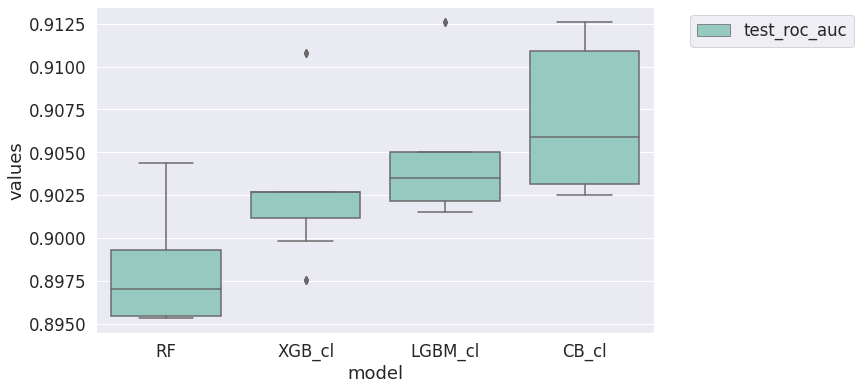

In [ ]:
# посмотрим на распределение на визуализации в виде боксплота  

plt.figure(figsize=(10, 6))
sns.set(font_scale=1.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);  

In [ ]:
# обучим модель и посмотрим на матрицу ошибок  

cb_model = CatBoostClassifier(silent=True)  

cb_model.fit(X_train, y_train)
y_prob = cb_model.predict_proba(X_valid)[:,1]  

In [ ]:
y_pred = np.where(y_prob > 0.45, 1, 0)  

In [ ]:
conf_matrix = confusion_matrix(y_valid.values.tolist(), y_pred.tolist())
conf_matrix  

array([[7455,  751],
       [ 927, 2203]])

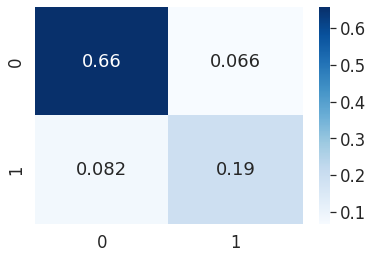

In [ ]:
sns.heatmap(conf_matrix / len(y_valid), cmap='Blues', annot=True);  

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc  

0.9129322501496995

Text(0.5, 0, 'False Positive Rate')

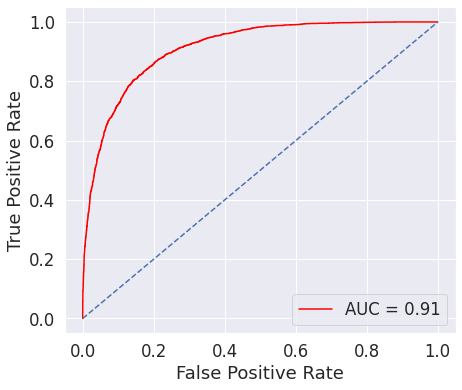

In [ ]:
plt.figure(figsize=(7, 6))  
plt.plot(false_positive_rate, true_positive_rate, color='red', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# PCA для визуализации данных  

In [ ]:
# используем PCA, чтобы уменьшить данные до 2-х измерений, так мы сможем посмотреть разделение на классы на графике  
# перед использованием PCA необходимо стандартизировать признаки с помощью StandardScaler  

x_pca = X  
y_pca = y  
x_pca = StandardScaler().fit_transform(x_pca)

In [ ]:
pca = PCA(n_components=2)
pca_train = pca.fit_transform(x_pca)  

principal_train_Df = pd.DataFrame(data = pca_train, columns = ['principal component 1', 'principal component 2'])  
principal_train_Df['y'] = y_pca    

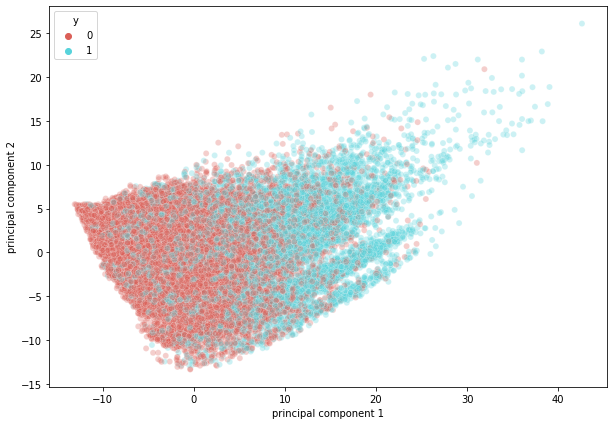

In [ ]:
# на графике видно, что разделение на классы присутствует, но классы не очень хорошо отделены друг от друга  

plt.figure(figsize=(10,7))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=principal_train_Df,
    legend="full",
    alpha=0.3
);  

# PCA для ускорения обучения  

In [ ]:
scaler = StandardScaler()  

scaler.fit(X_train)  
train_pca = scaler.transform(X_train)
valid_pca = scaler.transform(X_valid)  

In [ ]:
pca = PCA(.95)  
pca.fit(train_pca)

PCA(n_components=0.95)

In [ ]:
train_pca = pca.transform(train_pca)
valid_pca = pca.transform(valid_pca)  

In [ ]:
# ROC-AUC снизился, оставим датасет без изменений  

cb_model = CatBoostClassifier(silent=True)  

cb_model.fit(train_pca, y_train)
y_prob = cb_model.predict_proba(valid_pca)[:,1]  

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc  

0.9020748085052703

#  Отбор признаков    и кросс-валидация  

In [ ]:
# сохраним признаки с учетом их важности в датафрейм  

cb_model = CatBoostClassifier(silent=True)  
cb_model.fit(X_train, y_train)  

feature_imp = pd.DataFrame(sorted(zip(cb_model.feature_importances_, X_train.columns)), columns=['Value', 'Feature'])
feature_imp.sort_values(by='Value', ascending=False).head()  

,Value,Feature
237,12.390305,N_79
236,2.423681,C_4
235,2.261998,N_69
234,2.013366,corr1_N_66
233,1.728188,N_78


In [ ]:
l = []  
a = sorted(list(set(feature_imp['Value'])))  

for i in  a[:-1]:  
  new_features = list(feature_imp['Feature'][feature_imp.Value >= i])  
  X_train_imp = X_train[new_features]
  X_valid_imp = X_valid[new_features]
  cb_model = CatBoostClassifier(silent=True)  
  cb_model.fit(X_train_imp, y_train)
  y_pred = cb_model.predict(X_valid_imp)  
  roc_auc = roc_auc_score(y_valid, y_pred)
  l.append(roc_auc)  


In [ ]:
roc_auc_total = pd.DataFrame({'Value': a[:-1], 'Score': l})  
roc_auc_total.sort_values(by='Score', ascending=False).head()  

,Value,Score
15,0.021056,0.800621
48,0.060879,0.800606
160,0.602139,0.800285
24,0.028544,0.800280
72,0.119827,0.799853


In [ ]:
# сохраним набор признаков, который дает наилучший результат  

new_features = list(feature_imp['Feature'][feature_imp.Value > 0.021056])
print('All features:', len(feature_imp))
print('New features:', len(feature_imp[feature_imp.Value > 0.021056]))

X1 = X[new_features]  
test1 = test[new_features]  

All features: 238
New features: 200


In [ ]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(X1.shape[0])
sub_preds = np.zeros(test1.shape[0])  

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X1)):
    X_train, y_train = X1.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X1.iloc[valid_idx], y.iloc[valid_idx]
    
    cb_model = CatBoostClassifier(eval_metric='AUC', silent=True)  
    
    cb_model.fit(X_train, y_train, 
                 eval_set= [(X_train, y_train), (X_valid, y_valid)], 
                 verbose=250, 
                 early_stopping_rounds=150
                 )
    
    oof_preds[valid_idx] = cb_model.predict_proba(X_valid)[:, 1]
    sub_preds += cb_model.predict_proba(test1)[:, 1] / folds.n_splits
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(y_valid, oof_preds[valid_idx])))
    
    del cb_model, X_train, y_train, X_valid, y_valid  
    
print('Full AUC score %.6f' % roc_auc_score(y, oof_preds))   


Learning rate set to 0.081294
0:	test: 0.8736649	test1: 0.8652354	best: 0.8652354 (0)	total: 88.5ms	remaining: 1m 28s
250:	test: 0.9291060	test1: 0.9026700	best: 0.9026915 (238)	total: 17.1s	remaining: 50.9s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.9026915097
bestIteration = 238

Shrink model to first 239 iterations.
Fold  1 AUC : 0.902692
Learning rate set to 0.081295
0:	test: 0.8666626	test1: 0.8696444	best: 0.8696444 (0)	total: 79.6ms	remaining: 1m 19s
250:	test: 0.9260665	test1: 0.9126022	best: 0.9126111 (241)	total: 17s	remaining: 50.7s
500:	test: 0.9451808	test1: 0.9133863	best: 0.9135461 (491)	total: 33.5s	remaining: 33.4s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.9135460675
bestIteration = 491

Shrink model to first 492 iterations.
Fold  2 AUC : 0.913546
Learning rate set to 0.081295
0:	test: 0.8649003	test1: 0.8608061	best: 0.8608061 (0)	total: 81.4ms	remaining: 1m 21s
250:	test: 0.9290240	test1: 0.9046834	best: 0.9046952 

In [ ]:
sub_preds

array([0.15966723, 0.8995578 , 0.05391137, ..., 0.03624975, 0.80899596,
       0.11789205])

In [ ]:
#  сохраним резльтат для отправки  на проверку    

test_sub = pd.read_csv('/content/r42_welcome_test.csv', sep=';')  

submission = pd.DataFrame({
    'ID': test_sub['ID'],
    'Y': sub_preds
    })

submission.to_csv('submission_model.csv', index=False)

Наилучший  результат показала  модель CatBoost с отбором признаков - 0.90254  